packageのインストール方法
juliaを別途ターミナルから立ち上げて以下を入力

```
$ julia
julia> ここで]をおしてパッケージ管理モードに入る
(@v1.8) pkg> add CUDA Plots Revise
(@v1.8) pkg> add https://github.com/matsunagalab/MDToolbox.jl.git
(@v1.8) pkg> deleteをおしてパッケージ管理モードを抜ける
julia> Ctrl-dをおしてjuliaを終了
```

In [1]:
using CUDA
#using HTTP
using DelimitedFiles
using Plots
using ChainRulesCore
using ProgressMeter
using Revise
using MDToolbox
using LinearAlgebra

In [2]:
function set_charge(ta::TrjArray{T,U}) where {T,U}
    charge = Array{Int64}(undef, ta.natom)
    
    atomname = deepcopy(ta.atomname)
    
    is_first = true
    
    for iatom = 1:ta.natom
        # ATOM TYPE "N"
        if ta.atomname[iatom] == "N"
            if is_first
                charge[iatom] = 1
                is_first = false
            else
                charge[iatom] = 11
            end

            # ATOM TYPE "O"
        elseif ta.resname[iatom] == "O"
            charge[iatom] = 10
        elseif ta.resname[iatom] == "OXT"
            charge[iatom] = 2

        elseif ta.resname[iatom] == "ARG" && atomname[iatom] == "NH1"
            charge[iatom] = 3
        elseif ta.resname[iatom] == "ARG" && atomname[iatom] == "NH2"
            charge[iatom] = 3
        elseif ta.resname[iatom] == "GLU" && atomname[iatom] == "OE1"
            charge[iatom] = 4
        elseif ta.resname[iatom] == "GLU" && atomname[iatom] == "OE2"
            charge[iatom] = 4
        elseif ta.resname[iatom] == "ASP" && atomname[iatom] == "OD1"
            charge[iatom] = 5
        elseif ta.resname[iatom] == "ASP" && atomname[iatom] == "OD2"
            charge[iatom] = 5
        elseif ta.resname[iatom] == "LYS" && atomname[iatom] == "NZ"
            charge[iatom] = 6
        elseif ta.resname[iatom] == "PRO" && atomname[iatom] == "N"
            charge[iatom] = 7

        else
            charge[iatom] = 8
        
        end
    end
    
    return TrjArray(ta, charge=charge)
end

function get_charge_score()
    charge_score = Array{Float64}(undef, 11)
    charge_score[1] = 1.0 #TERMINAL-N
    charge_score[2] = -1.0 #TERMINAL-O
    charge_score[3] = 0.5 #ARG,NH
    charge_score[4] = -0.5 #GLU,OE
    charge_score[5] = -0.5 #ASP,OD
    charge_score[6] = 1.0 #LYS,NZ
    charge_score[7] = -0.1 #PRO,N
    charge_score[8] = 0.0 #CA
    charge_score[9] = 0.0 #C
    charge_score[10] = -0.5 #O
    charge_score[11] = 0.5 #N
    
    return charge_score
end

function assign_Li_charge!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_real .= zero(T)

    spread_nearest_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, charge_score)
    return nothing
end

function assign_Re_charge!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_real .= zero(T)

    spread_nearest_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, charge_score)
    return nothing
end

# function spread_neighbors_add_potential!(grid::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}

#     natom = length(x)
#     nx, ny, nz = size(grid)
#     for iatom = 1:natom
#         for ix = 1:nx
#             dx = x[iatom] - x_grid[ix]
#             if abs(dx) > rcut[iatom]
#                 continue
#             end
#             for iy = 1:ny
#                 dy = y[iatom] - y_grid[iy]
#                 if abs(dy) > rcut[iatom]
#                     continue
#                 end
#                 for iz = 1:nz
#                     dz = z[iatom] - z_grid[iz]
#                     if abs(dz) > rcut[iatom]
#                         continue
#                     end
#                     d = dx * dx + dy * dy + dz * dz
#                     if d < rcut[iatom] * rcut[iatom]
#                         grid[ix, iy, iz] += weight[iatom]　/ sqrt(d)
#                     end
#                 end
#             end
#         end
#     end

#     return nothing
# end

function calculate_distance!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}
    
    grid .= zero(T)
    
    natom = length(x)
    nx, ny, nz = size(grid)
    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] += sqrt(d)
                    end
                end
            end
        end
    end
    
    return nothing
end

function assign_Re_potential!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_charge = similar(grid_imag)
    grid_dis = similar(grid_imag)
    
    
    grid_charge .= zero(T)
    grid_dis .= zero(T)
    
    rcut = similar(charge_score)
    rcut .= T(8.0)
    
    spread_nearest_add!(grid_charge, x, y, z, x_grid, y_grid, z_grid, charge_score)
    calculate_distance!(grid_dis, x, y, z, x_grid, y_grid, z_grid, charge_score, rcut)
    
    grid_imag = grid_charge ./ grid_dis
    
    return nothing
end

function assign_Li_potential!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_charge = similar(grid_imag)
    grid_dis = similar(grid_imag)
    
    
    grid_charge .= zero(T)
    grid_dis .= zero(T)
    
    rcut = similar(charge_score)
    rcut .= T(8.0)
    
    spread_nearest_add!(grid_charge, x, y, z, x_grid, y_grid, z_grid, charge_score)
    calculate_distance!(grid_dis, x, y, z, x_grid, y_grid, z_grid, charge_score, rcut)
    
    grid_imag = grid_charge ./ grid_dis
    
    return nothing
end

assign_Li_potential! (generic function with 1 method)

In [3]:
function print_all!(x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T}) where{T}
    
    println(x,typeof(x),size(x))
    println(typeof(y),size(y))
    println(typeof(z),size(z))
    println(x_grid,typeof(x_grid),size(x_grid))
    println(typeof(y_grid),size(y_grid))
    println(typeof(z_grid),size(z_grid))
                                    
    return nothing
end

print_all! (generic function with 1 method)

In [4]:

################ grid

function generate_grid(receptor_org::TrjArray{T,U}, ligand_org::TrjArray{T,U}; iframe=1, spacing=1.2) where {T,U}
    receptor = deepcopy(receptor_org)
    ligand = deepcopy(ligand_org)
    decenter!(receptor)
    orient!(ligand)
    xmin_ligand = minimum(ligand.xyz[iframe, 1:3:end])
    xmax_ligand = maximum(ligand.xyz[iframe, 1:3:end])
    size_ligand = xmax_ligand - xmin_ligand

    xmin_receptor = minimum(receptor.xyz[iframe, 1:3:end])
    xmax_receptor = maximum(receptor.xyz[iframe, 1:3:end])
    xmin_grid = xmin_receptor - size_ligand - spacing
    xmax_grid = xmax_receptor + size_ligand + spacing

    ymin_receptor = minimum(receptor.xyz[iframe, 2:3:end])
    ymax_receptor = maximum(receptor.xyz[iframe, 2:3:end])
    ymin_grid = ymin_receptor - size_ligand - spacing
    ymax_grid = ymax_receptor + size_ligand + spacing

    zmin_receptor = minimum(receptor.xyz[iframe, 3:3:end])
    zmax_receptor = maximum(receptor.xyz[iframe, 3:3:end])
    zmin_grid = zmin_receptor - size_ligand - spacing
    zmax_grid = zmax_receptor + size_ligand + spacing

    x_grid = Array{T,1}(range(xmin_grid, xmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        x_grid = CuArray(x_grid)
    end

    y_grid = Array{T,1}(range(ymin_grid, ymax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        y_grid = CuArray(y_grid)
    end

    z_grid = Array{T,1}(range(zmin_grid, zmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        z_grid = CuArray(z_grid)
    end

    nx = length(x_grid)
    ny = length(y_grid)
    nz = length(z_grid)

    grid_real = similar(receptor_org.xyz, (nx, ny, nz))
    grid_real .= zero(T)
    grid_imag = similar(receptor_org.xyz, (nx, ny, nz))
    grid_imag .= zero(T)

    return grid_real, grid_imag, x_grid, y_grid, z_grid
end

function spread_nearest_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] += weight[iatom]
    end

    return nothing
end

function spread_nearest_substitute!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] = weight[iatom]
    end

    return nothing
end

function spread_neighbors_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}

    natom = length(x)
    nx, ny, nz = size(grid)
    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] += weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


function spread_neighbors_substitute!(grid::AbstractArray{T2},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T2,T}

    natom = length(x)
    nx, ny, nz = size(grid)

    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] = weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


#####################################################

function assign_sc_receptor_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_ligand_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_receptor_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.5)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
    
function assign_sc_ligand_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.5)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
###################################################

# function assign_sc_receptor!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     x_s = x[id_surface]
#     y_s = y[id_surface]
#     z_s = z[id_surface]
#     radius_s = radius[id_surface]
#     weight_s = similar(radius_s)

#     x_c = x[.!id_surface]
#     y_c = y[.!id_surface]
#     z_c = z[.!id_surface]
#     radius_c = radius[.!id_surface]
#     weight_c = similar(radius_c)

#     weight_s .= T(1.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
#     weight_s .= T(0.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
#     weight_c .= T(0.0)
#     spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

#     weight_s .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
#     weight_c .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
#     return nothing
# end

# function assign_sc_ligand!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     x_s = x[id_surface]
#     y_s = y[id_surface]
#     z_s = z[id_surface]
#     radius_s = radius[id_surface]
#     weight_s = similar(radius_s)

#     x_c = x[.!id_surface]
#     y_c = y[.!id_surface]
#     z_c = z[.!id_surface]
#     radius_c = radius[.!id_surface]
#     weight_c = similar(radius_c)
    
#     weight_s .= T(1.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

#     weight_c .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

#     # check_neighbors_ligand!(grid_real, grid_imag)

#     return nothing
# end

function assign_Rij!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    iface_ij::AbstractVector{T}) where {T}

    grid_real .= zero(T)

    radius = similar(iface_ij)
    radius .= T(6.0)
    spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

    return nothing
end

function assign_Li!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T}
    ) where {T}

    grid_real .= zero(T)

    radius = similar(x)
    radius .= T(1.0)
    spread_nearest_substitute!(grid_real, x, y, z, x_grid, y_grid, z_grid, radius)

    return nothing
end

# function assign_ds!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     iface_ij::AbstractVector{T}) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     radius = similar(iface_ij)
#     radius .= T(6.0)
#     spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

#     radius .= T(1.0)
#     spread_nearest_substitute!(grid_imag, x, y, z, x_grid, y_grid, z_grid, radius)

#     return nothing
# end

################ docking

function docking_score_elec(receptor_org::TrjArray{T,U},
        ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractArray{T}, 
        beta::T, charge_score::AbstractArray{T}) where {T,U}
    spacing = 3.0
    receptor = deepcopy(receptor_org)
    ligands = deepcopy(ligands_org)

    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))
    
    grid_iface = similar(grid_real)
    grid_elec = similar(grid_imag)

    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
    ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

    # receptor.mass .= iface_ij[receptor.atomtype_id]
    # ligands.mass .= iface_ij[ligands.atomtype_id]

    x = receptor.xyz[1, 1:3:end]
    y = receptor.xyz[1, 2:3:end]
    z = receptor.xyz[1, 3:3:end]
    id_surface = receptor.sasa .> 1.0
    
#     print(typeof(receptor.xyz),size(receptor.xyz))
#     print(typeof(ligands.xyz),size(ligands.xyz))    
#     print_all!(x, y, z, x_grid, y_grid, z_grid)   
    
     
#     function calculate_atom_distances(receptor::TrjArray{T,U}, ligands::TrjArray{T,U}, 
#             x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T})
#         m, n = length(x), length(y)
#         distances = similar(x, m, n)
#         for i in 1:m
#             for j in 1:n
#                 distances[i, j] = sqrt((receptor.xyz[i, 1] - ligands.xyz[j, 1])^2 +
#                 　　　　　　　　　　　(receptor.xyz[i, 2] - ligands.xyz[j, 2])^2 +
#                                   (receptor.xyz[i, 3] - ligands.xyz[j, 3])^2)
#             end
#         end
 
#         return distances
#     end
    
#     atom_distances = calculate_atom_distances(receptor, ligands, x, y, z)
    

    ##########################################
    
    assign_sc_receptor_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    assign_sc_receptor_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    #assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    grid_sc_receptor = grid_real .+ im .* grid_imag
    
    ##########################################

    # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
    # grid_ds_receptor = grid_real .+ im .* grid_imag
    
#     print_all!(x, y, z, x_grid, y_grid, z_grid)   

    x = ligands.xyz[1, 1:3:end]
    y = ligands.xyz[1, 2:3:end]
    z = ligands.xyz[1, 3:3:end]

    x2 = receptor.xyz[1, 1:3:end]
    y2 = receptor.xyz[1, 2:3:end]
    z2 = receptor.xyz[1, 3:3:end]

    id_surface = ligands.sasa .> 1.0

    grid_sc_ligand = deepcopy(grid_sc_receptor)
    # grid_iface_ligand = deepcopy(grid_real)
    # grid_iface_receptor = deepcopy(grid_real)
    score_sc = similar(grid_real, ligands.nframe)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_elec = similar(grid_real, ligands.nframe)
    score_elec .= zero(T)
    score_total = similar(grid_real, ligands.nframe)

    @showprogress for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]

        ###################################################
        
#         assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
#         grid_sc_ligand .= grid_real .+ im .* grid_imag
#         multi = grid_sc_receptor .* grid_sc_ligand
#         score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))

        assign_sc_ligand_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        assign_sc_ligand_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag 
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi)) 
        
        
        ##################################################        
        
        # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
        # grid_ds_ligand .= grid_real .+ im .* grid_imag
        # multi = grid_ds_receptor .* grid_ds_ligand
        # score_ds[iframe] = T(0.5) * sum(imag(multi))

        for i = 1:12
            idx = ligands.atomtype_id .== i 
            assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
            grid_iface = grid_real
            for j = 1:12
                k = 12 * (j-1) + i 
                receptor.mass .= iface_ij[k]
                idx = receptor.atomtype_id .== j
                assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                score_iface[iframe] += sum(grid_real .* grid_imag)
            end
        end 
        
        for l = 1:11
            idx = ligands.atomtype_id .== l
            idx2 = receptor.atomtype_id .== l
            ligands.mass .= charge_score[l]
            receptor.mass .= charge_score[l]
            assign_Li_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligands.mass[idx])
            assign_Re_potential!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])
            score_elec[iframe] += sum(grid_real .* grid_imag)
            grid_elec = grid_imag            
        end

        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe] .+ beta .* score_elec[iframe]
    end

#     print_all!(x, y, z, x_grid, y_grid, z_grid)
    
    return score_total
end


docking_score_elec (generic function with 1 method)

In [5]:
function docking_score(receptor_org::TrjArray{T,U},
        ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractArray{T}
        ) where {T,U}
    spacing = 3.0
    receptor = deepcopy(receptor_org)
    ligands = deepcopy(ligands_org)

    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))

    
    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
    ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

    # receptor.mass .= iface_ij[receptor.atomtype_id]
    # ligands.mass .= iface_ij[ligands.atomtype_id]

    x = receptor.xyz[1, 1:3:end]
    y = receptor.xyz[1, 2:3:end]
    z = receptor.xyz[1, 3:3:end]
    id_surface = receptor.sasa .> 1.0

    ##########################################
    
    assign_sc_receptor_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    assign_sc_receptor_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    #assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    grid_sc_receptor = grid_real .+ im .* grid_imag
    
    ##########################################

    # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
    # grid_ds_receptor = grid_real .+ im .* grid_imag

    x = ligands.xyz[1, 1:3:end]
    y = ligands.xyz[1, 2:3:end]
    z = ligands.xyz[1, 3:3:end]

    x2 = receptor.xyz[1, 1:3:end]
    y2 = receptor.xyz[1, 2:3:end]
    z2 = receptor.xyz[1, 3:3:end]

    id_surface = ligands.sasa .> 1.0

    grid_sc_ligand = deepcopy(grid_sc_receptor)
    # grid_iface_ligand = deepcopy(grid_real)
    # grid_iface_receptor = deepcopy(grid_real)
    score_sc = similar(grid_real, ligands.nframe)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_total = similar(grid_real, ligands.nframe)

    @showprogress for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]

        ###################################################
        
#         assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
#         grid_sc_ligand .= grid_real .+ im .* grid_imag
#         multi = grid_sc_receptor .* grid_sc_ligand
#         score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))

        assign_sc_ligand_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        assign_sc_ligand_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag 
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi)) 
        
        
        ##################################################        
        
        # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
        # grid_ds_ligand .= grid_real .+ im .* grid_imag
        # multi = grid_ds_receptor .* grid_ds_ligand
        # score_ds[iframe] = T(0.5) * sum(imag(multi))

        for i = 1:12
            idx = ligands.atomtype_id .== i 
            assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
            for j = 1:12
                k = 12 * (j-1) + i 
                receptor.mass .= iface_ij[k]
                idx = receptor.atomtype_id .== j
                assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                score_iface[iframe] += sum(grid_real .* grid_imag)
            end
        end 


        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe] 
    end

    return score_total
end


docking_score (generic function with 1 method)

In [6]:
function ChainRulesCore.rrule(::typeof(docking_score_elec), receptor_org::TrjArray{T,U}, ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractVector{T}, beta::T, charge_score::AbstractArray{T}) where {T,U} 
    spacing = 1.5 
    receptor = deepcopy(receptor_org) 
    ligands = deepcopy(ligands_org)
　　 
    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = MDToolbox.generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))

    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
　　 receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
　　 receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
　　 ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
　　 ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
　　 ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

# 　 receptor.mass .= iface_ij[receptor.atomtype_id]
# 　 ligands.mass .= iface_ij[ligands.atomtype_id]

　　 x = receptor.xyz[1, 1:3:end]
　　 y = receptor.xyz[1, 2:3:end]
　　 z = receptor.xyz[1, 3:3:end]
　　 id_surface = receptor.sasa .> 1.0

　　 assign_sc_receptor_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
　　 assign_sc_receptor_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
# 　 MDToolbox.assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
　　 grid_sc_receptor = grid_real .+ im .* grid_imag

# 　 assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
# 　 grid_ds_receptor = grid_real .+ im .* grid_imag

　　 x = ligands.xyz[1, 1:3:end]
　　 y = ligands.xyz[1, 2:3:end]
　　 z = ligands.xyz[1, 3:3:end]

　 　x2 = receptor.xyz[1, 1:3:end]
　　 y2 = receptor.xyz[1, 2:3:end]
　　 z2 = receptor.xyz[1, 3:3:end]

　　 id_surface = ligands.sasa .> 1.0

　　 grid_sc_ligand = deepcopy(grid_sc_receptor)
   
    score_sc = similar(grid_real, ligands.nframe)
    score_sc .= zero(T)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_elec = similar(grid_real, ligands.nframe)
    score_elec .= zero(T)
    data1 = similar(grid_real, length(iface_ij), ligands.nframe)
    data1 .= zero(T)
    data2 = similar(grid_real, length(charge_score), ligands.nframe)
    data2 .= zero(T)
    data3 = similar(grid_real, length(charge_score), ligands.nframe)
    data3 .= zero(T)
    score_total = similar(grid_real, ligands.nframe)
    cb = similar(grid_real, length(charge_score), ligands.nframe)

    score_for_ifacescore = similar(grid_real, length(iface_ij), ligands.nframe)
    score_for_chargescore = similar(grid_real, length(charge_score), ligands.nframe)
#     score_for_ifacescore = zeros(T, 12 * 12, ligands.nframe)
#     score_for_chargescore = zeros(T, 11, ligands.nframe)
    print("score")
　　 @showprogress for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]
    　　　　
        assign_sc_ligand_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        assign_sc_ligand_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
# 　　　　MDToolbox.assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))       

    　 　# assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
    　　 # grid_ds_ligand .= grid_real .+ im .* grid_imag
    　　 # multi = grid_ds_receptor .* grid_ds_ligand
    　　 # score_ds[iframe] = T(0.5) * sum(imag(multi))
　 
        for i = 1:12
            idx = ligands.atomtype_id .== i
            if any(idx)
                assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
# 　　　　　　　　　MDToolbox.assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
                for j = 1:12
                    k = 12 * (j-1) + i        　　       　　
                    receptor.mass .= iface_ij[k]
                    idx2 = receptor.atomtype_id .== j
                    if any(idx)
                        assign_Rij!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])
# 　　　　　　　　　     　MDToolbox.assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                        score_iface[iframe] += sum(grid_real .* grid_imag) 
                    end　
                end
            end
        end  
        for l = 1:11
     　　  　　 idx = ligands.atomtype_id .== l
        　　　　idx2 = receptor.atomtype_id .== l
            if any(idx)
                if any(idx2)
                    ligands.mass .= charge_score[l]
                    receptor.mass .= charge_score[l]
                    assign_Li_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligands.mass[idx])
                    assign_Re_potential!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])                    
                    score_elec[iframe] += sum(grid_real .* grid_imag)
#                     grid_imag .= zero(T)
#                     calculate_distance!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2]) 
#                     dis[iframe] += sum(grid_imag)    
                end　　
            end
        end   
        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe] .+ beta .* score_elec[iframe]
　　end 
　　score_sc_old = deepcopy(score_sc)
　　score_elec_old = deepcopy(score_elec)
    
    
    ####################################################
    print("score_for_iface")
    @showprogress for iframe = 1:ligands.nframe              
        receptor.mass .= zero(T)
        ligands.mass .= zero(T)
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]
    
        for i = 1:12
            idx = ligands.atomtype_id .== i
            ligands.mass[idx] .= one(T)
            if any(idx)
                assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
# 　　　　　　　　　MDToolbox.assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
                for j = 1:12
                    k = 12 * (j-1) + i  
                    k_dual = 12 * (i-1) + j
                    idx2 = receptor.atomtype_id .== j
                    receptor.mass[idx2] .= one(T)
                    if any(idx2)
                        assign_Rij!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])
# 　　　　　　　　　     　MDToolbox.assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                        tmp = sum(grid_real .* grid_imag)
                        data1[k, iframe] = tmp
                        data1[k_dual, iframe] = tmp 
                        score_for_ifacescore = data1
                    end　
                end
            end
        end  
    end

    
###########################################################
#      print("score_for_iface")
#     @showprogress for itype = 1:length(iface_ij)
#         receptor.mass .= zero(T)
#         ligands.mass .= zero(T)
#         idx = receptor.atomtype_id .== iface_ij[itype]
#         receptor.mass[idx] .= one(T)

#         x = receptor.xyz[1, 1:3:end]
#         y = receptor.xyz[1, 2:3:end]
#         z = receptor.xyz[1, 3:3:end]
#         id_surface = receptor.sasa .> 1.0
    
#         assign_Rij!(grid_imag, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, receptor.mass[idx])

#         idx = ligands.atomtype_id .== iface_ij[itype]
#         ligands.mass[idx] .= one(T)

#         x = ligands.xyz[1, 1:3:end]
#         y = ligands.xyz[1, 2:3:end]
#         z = ligands.xyz[1, 3:3:end]
#         id_surface = ligands.sasa .> 1.0

#         for iframe = 1:ligands.nframe
#             x .= ligands.xyz[iframe, 1:3:end]
#             y .= ligands.xyz[iframe, 2:3:end]
#             z .= ligands.xyz[iframe, 3:3:end]

#             for i = 1:12
#                 idx = ligands.atomtype_id .== i
#                 if any(idx)
#                     assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
# # 　　　　　　　　　MDToolbox.assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
#                     for j = 1:12
#                         k = 12 * (j-1) + i  
#                         k_dual = 12 * (i-1) + j
#                         idx2 = receptor.atomtype_id .== j
#                         if any(idx2)
#                             assign_Rij!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])
# # 　　　　　　　　　     　MDToolbox.assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
#                             tmp = sum(grid_real .* grid_imag)
#                             data1[k, iframe] = tmp
#                             data1[k_dual, iframe] = tmp 
#                         end　
#                     end
#                 end
#             end 
#             score_for_ifacescore[itype, iframe] = data1[iframe] 
#        end
#     end

###########################################################score_for_ifacescore
    print("score_for_chargescore")
    @showprogress for iframe = 1:ligands.nframe
        receptor.mass .= zero(T)
        ligands.mass .= zero(T)
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]
    
        for l = 1:11
            idx = ligands.atomtype_id .== l
            idx2 = receptor.atomtype_id .== l
            if any(idx)
                if any(idx2)
                    ligands.mass[idx] .= charge_score[l]
                    receptor.mass[idx2] .= one(T)
                    assign_Re_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligands.mass[idx])
                    assign_Li_potential!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])                    
                    data2[l, iframe] = sum(grid_real .* grid_imag)
                    score_for_chargescore = data2
#                     grid_imag .= zero(T)
#                     calculate_distance!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2]) 
#                     dis[iframe] += sum(grid_imag) 
                end 
            end
        end  
            # score_for_acescore[iscore, iframe] = alpha .* score_sc[iframe] .+ score_ds[iframe] 
    end
    @showprogress for iframe = 1:ligands.nframe       
        receptor.mass .= zero(T)
        ligands.mass .= zero(T)
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]
    
        for l = 1:11
            idx = ligands.atomtype_id .== l
            idx2 = receptor.atomtype_id .== l
            if any(idx)
                if any(idx2)
                    ligands.mass[idx] .= one(T)
                    receptor.mass[idx2] .= charge_score[l]
                    assign_Li_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligands.mass[idx])
                    assign_Re_potential!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])                    
                    data3[l, iframe] = sum(grid_real .* grid_imag)
                    score_for_chargescore += data3
#                     grid_imag .= zero(T)
#                     calculate_distance!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2]) 
#                     dis[iframe] += sum(grid_imag) 
                end 
            end
        end  
            # score_for_acescore[iscore, iframe] = alpha .* score_sc[iframe] .+ score_ds[iframe] 
    end
    
    
#     score_for_ifacescore = iface_ij
#     score_for_chargescore = charge_score
    
#     score_for_ifacescore = reshape(repeat(iface_ij, 100), 144, 100)
#     score_for_chargescore = reshape(repeat(charge_score, 100), 11, 100)    

#     println("beta=",beta)
#     println("bata=",typeof(beta))
#     println("beta=",size(beta))
#     println("iface=",score_for_ifacescore)
#     println("iface=",typeof(score_for_ifacescore))
#     println("iface=",size(score_for_ifacescore))     
#     println("charge=",score_for_chargescore)
#     println("charge=",typeof(score_for_chargescore))
#     println("charge=",size(score_for_chargescore)) 
    
　　
#     for iframe = 1:ligands.nframe
# 　　　　x .= ligands.xyz[iframe, 1:3:end]
# 　　　　y .= ligands.xyz[iframe, 2:3:end]
# 　　　　z .= ligands.xyz[iframe, 3:3:end]
# 　　　　for i = 1:12
# 　　　　　　idx = ligands.atomtype_id .== i
# 　　　　　　if any(idx)
# 　　　　　　　　assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
# # 　　　　　　　MDToolbox.assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
# 　　　　　　　　for j = 1:12
# 　　　　　　　　　　 k = 12 * (j-1) + i
# 　　　　　　　　　　receptor.mass .= iface_ij[k]
# 　　　　　　　　　　idx = receptor.atomtype_id .== j
# 　　　　　　　　　　if any(idx)
# 　　　　　　　　　　assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
# #　　　　　　　　　 MDToolbox.assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
# 　　　　　　　　　　score_iface[iframe] += sum(grid_real .* grid_imag)
# 　　　　　　　　end
# 　　　　　　end
# 　　　　end
# 　　　　for l = 1:11
# 　　　　　　idx = ligands.atomtype_id .== l
# 　　　　　　idx2 = receptor.atomtype_id .== l
# 　　　　　　ligands.mass .= charge_score[l]
# 　　　　　　receptor.mass .= charge_score[l]
# 　　　　　　assign_Li_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligands.mass[idx])
# 　　　　　　assign_Re_potential!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])
# 　　　　　　score_elec[iframe] += sum(grid_real .* grid_imag)
# 　　　　end
# 　　end
   
    
      　　  　　
#     for l = 1:11
#         idx = ligands.atomtype_id .== l
#         idx2 = receptor.atomtype_id .== l
#         if any(idx)
#             if any(idx2)
#                 ligands.mass .= charge_score[l]
#                 receptor.mass .= charge_score[l]
#                 calculate_distance!(grid_imag, x2[idx2], y2[idx2], z2[idx2], x_grid, y_grid, z_grid, receptor.mass[idx2])
#                 d = sum(grid_imag)
#             end
#         end　　
#     end 
 

　　function pullback(ybar)  
        println("loss")   
        sber = NoTangent()
        rber = NoTangent()
        lber = NoTangent()
        aber = sum(score_sc_old .* ybar)
        ifber = zeros(144)
        for a in 1:144
            sfi = score_for_ifacescore[a,:]
#             println(sfi)
            ifber[a] = LinearAlgebra.dot(sfi,ybar)
        end
        bber = sum(score_elec_old .* ybar)
        chber = zeros(11)
        for b in 1:11 
            sfc = score_for_chargescore[b,:]
            cb[b] = LinearAlgebra.dot(sfc,ybar)
            chber[b] = beta .* cb[b]
        end
#        println(aber)
#     　　println(typeof(aber))
#     　　println(size(aber))    　
#         println(score_for_ifacescore)
#     　　println(typeof(score_for_ifacescore))
#     　　println(size(score_for_ifacescore))
#     　　println(ifber)
#     　　println(typeof(ifber))
#     　　println(size(ifber))
#     　　println(bber)
#     　　println(typeof(bber))
#     　　println(size(bber))
    　　println(chber)
    　　println(typeof(chber))
    　　println(size(chber))
            
    　　return sber, rber, lber, aber, ifber, bber, chber
　　end

　　return score_total, pullback
end

In [7]:
#device!(2)

In [8]:
#CUDA.cu(rand(3,3))

In [9]:
ENV["COLUMNS"]=130; #display width for MDToolbox

# load deocoy structures

In [10]:
ntop = 100

100

In [11]:
pdb = mdload("protein/1KXQ/complex.1.pdb")
receptor_k = pdb[1:1, 1:3908]
ligands_k = pdb[1:1, 3909:end]

for i = 2:ntop
    pdb = mdload("protein/1KXQ/complex.$(i).pdb")
    ligands_k = [ligands_k; pdb[1:1, 3909:end]]
end

In [12]:
pdb = mdload("protein/1F51/complex.1.pdb")
receptor_f = pdb[1:1, 1:2490]
ligands_f = pdb[1:1, 2491:end]

for i = 2:ntop
    pdb = mdload("protein/1F51/complex.$(i).pdb")
    ligands_f = [ligands_f; pdb[1:1, 2491:end]]
end

In [13]:
pdb = mdload("protein/2VDB/complex.1.pdb")
receptor_2v = pdb[1:1, 1:4493]
ligands_2v = pdb[1:1, 4494:end]

for i = 2:ntop
    pdb = mdload("protein/2VDB/complex.$(i).pdb")
    ligands_2v = [ligands_2v; pdb[1:1, 4494:end]]
end

In [14]:
d = readdlm("protein/1KXQ/1KXQ.zd3.0.2.fg.fixed.out.rmsds")
rmsds_k = d[1:ntop, 2]

100-element Vector{Float64}:
 11.19
  4.77
  4.77
 11.54
  4.29
  4.53
  5.33
  4.24
  4.42
 11.44
  3.89
  4.31
 11.12
  ⋮
 19.84
  0.93
 19.86
 19.66
 12.17
  5.03
  2.18
 12.62
 15.78
  4.79
  8.78
 19.18

In [15]:
d = readdlm("protein/1F51/1F51.zd3.0.2.fg.fixed.out.rmsds")
rmsds_f = d[1:ntop, 2]

100-element Vector{Float64}:
 21.85
 22.03
 21.68
 21.52
 21.88
 14.79
 21.74
 21.86
 21.99
 21.81
 21.78
  1.41
 13.26
  ⋮
 23.57
 14.84
 20.3
 23.05
 16.21
 22.2
 16.15
 22.2
 13.18
  9.79
 17.85
  1.96

In [16]:
d = readdlm("protein/2VDB/2VDB.zd3.0.2.fg.fixed.out.rmsds")
rmsds_2v = d[1:ntop, 2]

100-element Vector{Float64}:
 24.6
 28.21
 24.47
 15.12
 24.51
 27.6
 24.68
 23.51
 17.05
 25.12
 28.76
  9.83
 28.48
  ⋮
 14.58
 16.72
  0.66
 23.73
 23.5
  9.66
 24.75
 23.79
 17.14
 25.14
 28.45
  5.89

In [17]:
receptor_k

1x3908 TrjArray{Float64, Int64}
|                            |                            |  …                              |                            |
| 1GLN                       | 1GLN                       |  …   496LEU                     | 496LEU                     |
| 1N                         | 2CA                        |  …   3907CD2                    | 3908OXT                    |
|    14.38    -5.73    -7.54 |    13.09    -6.25    -7.94 |  …       6.66    -4.83    33.17 |    12.19    -5.56    32.58 |

In [18]:
ligands_k

100x916 TrjArray{Float64, Int64}
| H                          | H                          |  …   H                          | H                          |
| 1GLN                       | 1GLN                       |  …   120SER                     | 120SER                     |
| 18396N                     | 18397CA                    |  …   19310CB                    | 19311OXT                   |
|   -13.27    -8.89    -5.81 |   -12.60    -9.06    -7.12 |  …     -18.22    26.19   -28.69 |   -20.37    26.92   -27.07 |
|   -25.91    20.33    -7.94 |   -26.76    20.68    -9.09 |        -41.48   -14.84   -25.23 |   -39.48   -16.32   -23.97 |
|   -24.02    21.38    -7.94 |   -24.83    21.83    -9.09 |        -43.18   -11.96   -25.23 |   -41.35   -13.64   -23.97 |
|   -12.59    -9.93    -6.26 |   -12.08   -10.04    -7.65 |        -21.67    25.41   -27.41 |   -23.63    26.01   -25.52 |
|   -25.63    20.16    -7.06 |   -26.43    20.68    -8.19 |        -41.82   -12.11   -28.86 |   -39.92   -

In [19]:
# receptor_c

In [20]:
# ligands_c

# prepare docking score calculation

In [21]:
# vdW radius
receptor_k = MDToolbox.set_radius(receptor_k)
ligands_k = MDToolbox.set_radius(ligands_k)
receptor_f = MDToolbox.set_radius(receptor_f)
ligands_f = MDToolbox.set_radius(ligands_f)
receptor_2v = MDToolbox.set_radius(receptor_2v)
ligands_2v = MDToolbox.set_radius(ligands_2v);

In [22]:
# SASA
receptor_k = MDToolbox.compute_sasa(receptor_k)
ligands_k = MDToolbox.compute_sasa(ligands_k);

In [23]:
receptor_f = MDToolbox.compute_sasa(receptor_f)
ligands_f = MDToolbox.compute_sasa(ligands_f);

In [24]:
receptor_2v = MDToolbox.compute_sasa(receptor_2v)
ligands_2v = MDToolbox.compute_sasa(ligands_2v);

In [25]:
# IFACE scores
receptor_k = MDToolbox.set_atomtype_id(receptor_k)
ligands_k = MDToolbox.set_atomtype_id(ligands_k)
receptor_f = MDToolbox.set_atomtype_id(receptor_f)
ligands_f = MDToolbox.set_atomtype_id(ligands_f)
receptor_2v = MDToolbox.set_atomtype_id(receptor_2v)
ligands_2v = MDToolbox.set_atomtype_id(ligands_2v)

iface_score = MDToolbox.get_iface_ij()
receptor_k = TrjArray(receptor_k, mass=iface_score[receptor_k.atomtype_id])
ligands_k = TrjArray(ligands_k, mass=iface_score[ligands_k.atomtype_id])
receptor_f = TrjArray(receptor_f, mass=iface_score[receptor_f.atomtype_id])
ligands_f = TrjArray(ligands_f, mass=iface_score[ligands_f.atomtype_id])
receptor_2v = TrjArray(receptor_2v, mass=iface_score[receptor_2v.atomtype_id])
ligands_2v = TrjArray(ligands_2v, mass=iface_score[ligands_2v.atomtype_id]);

In [26]:
# ELEC
receptor_k = set_charge(receptor_k)
ligands_k = set_charge(ligands_k)
receptor_f = set_charge(receptor_f)
ligands_f = set_charge(ligands_f)
receptor_2v = set_charge(receptor_2v)
ligands_2v = set_charge(ligands_2v)
charge = get_charge_score()
# receptor = TrjArray(receptor, mass=iface_score[receptor.atomtype_id])
# ligands = TrjArray(ligands, mass=charge[ligands.atomtype_id]);

In [27]:
#CUDA.device!(0)

In [28]:
#device!(1)

In [29]:
#gpu(receptor)

In [30]:
#receptor = gpu(receptor)

In [31]:
# if CUDA.functional()
#     receptor = gpu(receptor)
#     ligands = gpu(ligands)
# end

In [32]:
iface_score

12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [33]:
charge

11-element Vector{Float64}:
  1.0
 -1.0
  0.5
 -0.5
 -0.5
  1.0
 -0.1
  0.0
  0.0
 -0.5
  0.5

# perform docking score calculation for decoy structures

In [35]:
#current_score = MDToolbox.docking_score(receptor, ligands, 0.01f0, CUDA.cu(iface_score[1:end]))

In [36]:
# current_score_b = MDToolbox.docking_score(receptor, ligands, 0.01, iface_score[1:end])

In [37]:
current_score = docking_score(receptor_k, ligands_k, 0.01, iface_score[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


100-element Vector{Float64}:
 -3328.9873749999983
 -1773.0355000000004
 -1886.6553749999996
 -3459.843875000001
 -1912.5242500000015
 -1815.2205
 -1860.0711250000002
 -1750.2556249999996
 -1673.2411250000011
 -3121.626874999999
 -2137.3655000000003
 -1830.7558750000007
 -3854.3258749999995
     ⋮
 -3698.584750000001
 -2942.5206250000006
 -5300.199250000001
 -4317.379500000002
 -3506.8064999999997
 -1738.08075
 -3561.4915
 -3022.6696249999995
 -3259.107249999998
 -1882.1318750000005
 -2154.1402500000004
 -1940.7648749999996

In [38]:
score_k = docking_score_elec(receptor_k, ligands_k, 0.01, iface_score[1:end], 3.0, charge[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


100-element Vector{Float64}:
 -4649.876874999998
 -3014.5639
 -3106.7574749999994
 -4794.020075
 -3082.950850000002
 -3156.5786999999996
 -3073.4700249999996
 -2949.4102249999996
 -2984.794025000001
 -4572.510574999999
 -3443.2925000000005
 -2986.818475000001
 -5244.162574999999
     ⋮
 -4644.33445
 -3693.5184250000007
 -6477.089650000001
 -5368.225800000002
 -4797.2922
 -3012.04785
 -4540.1587
 -4372.167425
 -4588.615149999998
 -3007.9103750000004
 -3480.65565
 -2896.3299749999996

In [39]:
score_f = docking_score_elec(receptor_f, ligands_f, 0.01, iface_score[1:end], 3.0, charge[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


100-element Vector{Float64}:
 -3605.137350000001
 -3914.6700249999994
 -3882.11145
 -2744.8943000000004
 -3709.678100000001
     5.874799999999709
 -3233.1753999999996
 -3623.993299999999
 -3578.05665
 -3477.8505249999994
 -3182.3779250000002
  -814.440925
  -257.0916000000001
     ⋮
   295.46369999999973
   257.9026500000001
 -1998.3437500000005
 -2627.4970500000004
    54.49739999999994
 -3484.1458000000002
 -1637.3168
 -3575.6776
  -262.42442500000004
   234.24007499999973
 -1325.5760749999997
 -1679.2732000000003

In [40]:
score_2v = docking_score_elec(receptor_2v, ligands_2v, 0.01, iface_score[1:end], 3.0, charge[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


100-element Vector{Float64}:
  485.4631500000002
 -234.90957500000002
  376.601225
 -270.2905499999998
  346.5403499999999
 -242.09462500000024
  355.1641750000001
  332.72759999999994
 -756.8659250000004
  230.72574999999983
   49.464500000000044
  263.6680999999995
  -59.60294999999985
    ⋮
  498.20987500000035
 -724.0309999999996
 -401.0457999999999
  520.4716500000002
  697.1372499999997
  138.3988499999998
  369.1337
  301.7287000000002
 -341.5182500000003
  249.23817499999961
 -188.41372500000028
  400.1325750000004

In [41]:
# current_score_trained_b = MDToolbox.docking_score(receptor, ligands, 0.01, iface_trained[1:end])

In [42]:
# current_score_trained_a = docking_score(receptor, ligands, 0.01, iface_trained[1:end])

In [43]:
# score_elec = docking_score_elec(receptor, ligands, 0.01, iface_trained[1:end], 3.0, charge[1:end])

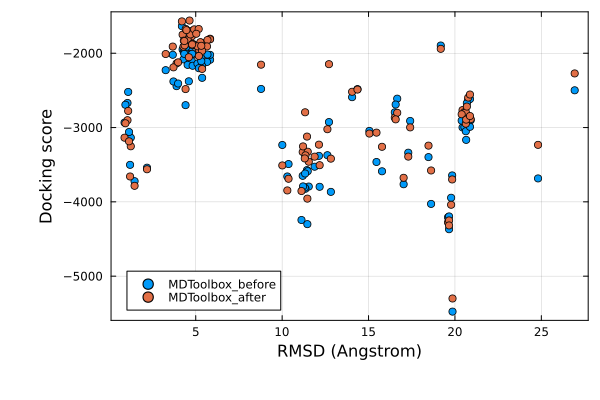

In [44]:
scatter(rmsds_k, score_k.+1000, 
        label="MDToolbox_before",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_k, current_score, 
        label="MDToolbox_after", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

# scatter!(rmsds_c, score_c, 
#         label="MDToolbox_after", 
#         xlabel="RMSD (Angstrom)", ylabel="Docking score", 
#         size=(600, 400), frame_style=:box, 
#         legend=:bottomleft, 
#         left_margin=Plots.Measures.Length(:mm, 10.0),
#         bottom_margin=Plots.Measures.Length(:mm, 10.0))

# create ideal scores as training data

In [45]:
# create training score
x1 = minimum(rmsds_k)
x2 = maximum(rmsds_k)

y1 = maximum(score_k)
y2 = minimum(score_k)

train_score_k = zeros(Float64, ntop)
for i = 1:ntop
    if rmsds_k[i] < 2.5
        train_score_k[i] = y1
    else
        train_score_k[i] = y2
    end     
end

In [46]:
# create training score
x1 = minimum(rmsds_f)
x2 = maximum(rmsds_f)

y1 = maximum(score_f)
y2 = minimum(score_f)

train_score_f = zeros(Float64, ntop)
for i = 1:ntop
    if rmsds_f[i] < 2.5
        train_score_f[i] = y1
    else
        train_score_f[i] = y2
    end
end

In [47]:
# create training score
x1 = minimum(rmsds_2v)
x2 = maximum(rmsds_2v)

y1 = maximum(score_2v)
y2 = minimum(score_2v)

train_score_2v = zeros(Float64, ntop)
for i = 1:ntop
    if rmsds_2v[i] < 2.5
        train_score_2v[i] = y1
    else
        train_score_2v[i] = y2
    end
end

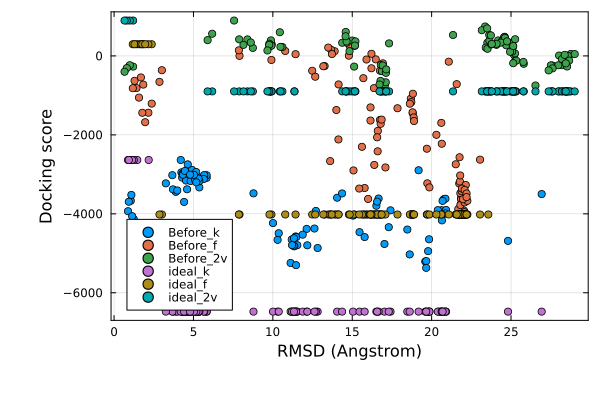

In [48]:
scatter(rmsds_k, score_k, 
        label="Before_k",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_f, score_f, 
        label="Before_f", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_2v, score_2v, 
        label="Before_2v", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_k, train_score_k, 
        label="ideal_k", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_f, train_score_f, 
        label="ideal_f", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_2v, train_score_2v, 
        label="ideal_2v", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

# define the docking score function as a layer of neural net framework (Flux.jl)

In [53]:
#ニューラルネットワークフレームワーク(Flux)のレイヤとしてドッキングスコア評価関数を定義

using Flux

struct DockingScore
    A::AbstractArray
    iface_score::AbstractArray
    B::AbstractArray
    charge::AbstractArray
end

DockingScore() = DockingScore(deepcopy([0.01]), deepcopy(iface_score[1:end]), deepcopy([3.0]), deepcopy(charge[1:end]))

Flux.@functor DockingScore (A,iface_score,B,charge)

(m::DockingScore)(x) = docking_score_elec(x[1], x[2], m.A[1], m.iface_score[1:end], m.B[1], m.charge[1:end])

In [54]:
# パラメータとして alpha と aces_core が認識されていることを確認
m = DockingScore()
ps = Flux.params(m)

Params([[0.01], [0.678, 0.133, -0.007, 0.727, 0.091, -0.742, -0.625, -0.064, -0.382, -0.302  …  0.109, 0.477, -0.034, -0.867, -1.04, 0.822, 0.757, -0.572, 0.731, 0.399], [3.0], [1.0, -1.0, 0.5, -0.5, -0.5, 1.0, -0.1, 0.0, 0.0, -0.5, 0.5]])

In [55]:
ps = ps |> Flux.gpu

┌ Info: The GPU function is being called but the GPU is not accessible. 
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).


Params([[0.01], [0.678, 0.133, -0.007, 0.727, 0.091, -0.742, -0.625, -0.064, -0.382, -0.302  …  0.109, 0.477, -0.034, -0.867, -1.04, 0.822, 0.757, -0.572, 0.731, 0.399], [3.0], [1.0, -1.0, 0.5, -0.5, -0.5, 1.0, -0.1, 0.0, 0.0, -0.5, 0.5]])

In [56]:
train_score1_1 = zeros(Float64, ntop)
train_score1_2 = zeros(Float64, ntop)
hit_1 = 0
for i = 1:ntop
    if rmsds_k[i] < 2.5
        train_score1_1[i] = train_score_k[i]
        train_score1_2[i] = score_k[i]
        hit_1 += 1
    else
        train_score1_1[i] = score_k[i]
        train_score1_2[i] = train_score_k[i]
    end
end

In [57]:
train_score2_1 = zeros(Float64, ntop)
train_score2_2 = zeros(Float64, ntop)
hit_2 = 0
for i = 1:ntop
    if rmsds_f[i] < 2.5
        train_score2_1[i] = train_score_f[i]
        train_score2_2[i] = score_f[i]
        hit_2 += 1
    else
        train_score2_1[i] = score_f[i]
        train_score2_2[i] = train_score_f[i]
    end
end

In [58]:
train_score3_1 = zeros(Float64, ntop)
train_score3_2 = zeros(Float64, ntop)
hit_3 = 0
for i = 1:ntop
    if rmsds_2v[i] < 2.5
        train_score3_1[i] = train_score_2v[i]
        train_score3_2[i] = score_2v[i]
        hit_3 += 1
    else
        train_score3_1[i] = score_2v[i]
        train_score3_2[i] = train_score_2v[i]
    end
end

In [59]:
print(hit_1,hit_2,hit_3)

9104

In [60]:
# 勾配クリッピング関数
function clipgrad!(grads, clip_value=1.0)
    for p in keys(grads)
        g = grads[p]
        if g !== nothing
            grads[p] .= clamp.(g, -clip_value, clip_value)
        end
    end
end

clipgrad! (generic function with 2 methods)

In [61]:
# # 勾配降下法によるパラメータの最適化

# loss(receptor_ligands, train_scores) = sum(Flux.Losses.mse.(m.(receptor_ligands), train_scores)) + 0.001 * sum(Flux.norm, Flux.params(m))

# train_loader = Flux.Data.DataLoader((data=[(receptor_k, ligands_k)], label=[train_score]), batchsize=1, shuffle=false);

# opt = ADAM(1e-5)
   
# loss_train = []
# print("a")
# for epoch in 1:5
#     print("b")
#     for (x, y) in train_loader
#         println("c")
#         gs = gradient(() -> loss(x, y), ps)
#         print("d")
#         Flux.Optimise.update!(opt, ps, gs)
#         print("e")
#     end
#     print("f")
#     push!(loss_train, loss([(receptor_k, ligands_k)], [train_score]))
# end

In [62]:
# 損失関数
function loss(rl_1, rl_2, rl_3, train1_1, train1_2, train2_1, train2_2, train3_1, train3_2)
    l = sum(Flux.Losses.mse.(m.(rl_1), train1_1)) / 9  
    + sum(Flux.Losses.mse.(m.(rl_1), train1_2)) / 91
    + sum(Flux.Losses.mse.(m.(rl_2), train2_1)) / 10
    + sum(Flux.Losses.mse.(m.(rl_2), train2_2)) / 90  
    + sum(Flux.Losses.mse.(m.(rl_3), train3_1)) / 4
    + sum(Flux.Losses.mse.(m.(rl_3), train3_2)) / 96
    return l
end

# データローダーの定義
train_loader = Flux.Data.DataLoader((data1=[(receptor_k, ligands_k)], data2=[(receptor_f, ligands_f)], data3=[(receptor_2v, ligands_2v)], 
               label1=[train_score1_1], label2=[train_score1_2], label3=[train_score2_1], label4=[train_score2_2], label5=[train_score3_1], label6=[train_score3_2]),
               batchsize=1, shuffle=false);

# オプティマイザーの定義
opt = ADAM(0.01)

# 損失の記録用リスト
loss_train = []

# 学習率のデバッグ出力
println("Initial learning rate: $(opt.eta)")

# トレーニングループ
for epoch in 1:200
    println("Epoch: $epoch")
    for (x1, x2, x3, y1, y2, y3, y4, y5, y6) in train_loader
 
        # 勾配の計算
        gs = gradient(() -> loss(x1, x2, x3, y1, y2, y3, y4, y5, y6), ps)
        
        # 勾配のデバッグ出力
#         println(gs.grads)
        
        # 勾配クリッピング
#         clipgrad!(gs.grads, 1.0)
        
        # パラメータの更新
        Flux.Optimise.update!(opt, ps, gs)
    end
    
    # トレーニング損失の計算
    current_loss = loss([(receptor_k, ligands_k)], [(receptor_f, ligands_f)], [(receptor_2v, ligands_2v)], [train_score1_1], [train_score1_2], [train_score2_1], [train_score2_2], [train_score3_1], [train_score3_2])
    println("Loss: $(current_loss)")
    println("\n")
    push!(loss_train, current_loss)
end

Initial learning rate: 0.01
Epoch: 1
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:05:15


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:16:49


score

Progress: 100%|█████████████████████████████████████████| Time: 1:28:39


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:36:34


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.5632829273437616e8, -1.503208219376761e9, -9.349191868980975e8, -3.2987230555080426e8, -5.0982818056417716e8, -3.641081357677619e8, -3.034557189196003e8, -2.7701883916333807e8, -2.0636818673778617e8, -4.882215371080347e8, -6.568150575555859e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 43225.15766011704


Epoch: 2
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.0009484910715524e7, -6.485198761794817e7, -5.79312989280786e7, -2.435937213366178e7, -3.060571477436122e7, -2.6403119482400417e7, -2.661527062485116e7, -2.0346691054237686e7, -1.0117384725620758e7, -2.018908933735653e7, -2.7995070349934804e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 108073.66875328253


Epoch: 3
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[9.596147215024628e7, 9.768522759977614e8, 5.772181811074293e8, 1.969092180391832e8, 3.164657072516079e8, 2.1817979282797363e8, 1.738872810186951e8, 1.6554784595949325e8, 1.3201493311095814e8, 3.187752233932219e8, 4.2741735438497454e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 127973.05185274051


Epoch: 4
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.1947816409004055e8, 1.2079775419726136e9, 7.181563822684592e8, 2.460156281022608e8, 3.934789375713498e8, 2.7245931578915936e8, 2.1838770938509035e8, 2.0680261324238557e8, 1.6355239450363407e8, 3.9398092826507556e8, 5.284636719812248e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 103169.79571429233


Epoch: 5
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[9.053000183664444e7, 9.233579813167229e8, 5.446377448213527e8, 1.8557546932513446e8, 2.9865996182288194e8, 2.0564953482755905e8, 1.6362339906142238e8, 1.5602388821919146e8, 1.2472105160760207e8, 3.0136594351018995e8, 4.0403766084422626e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 66787.33862534845


Epoch: 6
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.8148812997565806e7, 4.083876164989524e8, 2.306697551165936e8, 7.620701661922391e7, 1.2709372243003121e8, 8.475592859890805e7, 6.4522685026870094e7, 6.4138935658410296e7, 5.446028377969278e7, 1.337961568620325e8, 1.7890708484979954e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 39494.55182028151


Epoch: 7
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.791646717965617e7, -1.427999924977452e8, -1.0538020715174529e8, -4.085364121203525e7, -5.653905980566861e7, -4.4640599442555375e7, -4.154851618275661e7, -3.420862713528604e7, -2.074188699030442e7, -4.55584640719309e7, -6.2056833587189205e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26720.55117409174


Epoch: 8
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-6.0367089927419186e7, -5.601571614246513e8, -3.598300421515416e8, -1.2948650444327433e8, -1.9558229519909093e8, -1.4261413648320216e8, -1.2185987390518834e8, -1.0867324579734665e8, -7.768378759295276e7, -1.8136547857709548e8, -2.445125671299037e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 23358.556390791706


Epoch: 9
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-7.80417526069915e7, -7.339649629442929e8, -4.6578225299290437e8, -1.663868781835035e8, -2.5348041955889678e8, -1.8340421424574474e8, -1.55293644865837e8, -1.396757860286061e8, -1.0139529356689486e8, -2.379230391922348e8, -3.204933053447561e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24476.60573146424


Epoch: 10
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-7.070830318490888e7, -6.619383634159032e8, -4.218444303995808e8, -1.510702581550092e8, -2.294724924654359e8, -1.6647512065387452e8, -1.414107866011325e8, -1.2680908463025135e8, -9.156479886339298e7, -2.1448758036246735e8, -2.890002823681638e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 30095.23037602572


Epoch: 11
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-4.511890617328529e7, -4.1045177501763415e8, -2.684864773369944e8, -9.763520836526753e7, -1.4567291340967956e8, -1.074109807762718e8, -9.298676755180871e7, -8.191779612842363e7, -5.724855917921868e7, -1.3265691109774676e8, -1.790511100515553e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 41613.80061833365


Epoch: 12
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.0239210967457203e7, -6.764077570267454e7, -5.94458389785239e7, -2.4801896482833523e7, -3.1446062404754493e7, -2.690458522651205e7, -2.6984890270781156e7, -2.0729413208221372e7, -1.0471838797584094e7, -2.110982343706872e7, -2.9176792296921904e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 57429.791047548366


Epoch: 13
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.4394775819917012e7, 2.7275181392690146e8, 1.4812135503081706e8, 4.751861255658878e7, 8.197556222672877e7, 5.303490105752452e7, 3.855246460070398e7, 4.0028062984101236e7, 3.597506130612664e7, 8.965029337910488e7, 1.1964038551281137e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 71830.18861048619


Epoch: 14
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.996493576520292e7, 5.240412208533844e8, 3.0136204520756716e8, 1.0091410108892243e8, 1.6571086502972767e8, 1.1205514594513199e8, 8.69411029940175e7, 8.48859193392032e7, 7.02647932049678e7, 1.7141668188361338e8, 2.2950377708976388e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 78431.04406878853


Epoch: 15
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[6.078259158600438e7, 6.303075534487131e8, 3.6618045112461174e8, 1.235064951803767e8, 2.0112854162776828e8, 1.3702651147479758e8, 1.0741766623626938e8, 1.0386504255755764e8, 8.476752106098978e7, 2.0599332283419546e8, 2.7596640414841525e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 74919.47927801547


Epoch: 16
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[5.591890477636012e7, 5.824219029185902e8, 3.370098201081826e8, 1.133562387646151e8, 1.851867348934994e8, 1.2580510167293905e8, 9.82245023743561e7, 9.533598735903966e7, 7.823760041268872e7, 1.9040975065202478e8, 2.5503722506623592e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 64014.63513583959


Epoch: 17
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.847598192835035e7, 4.1087958990698355e8, 2.324432991006106e8, 7.694048020082596e7, 1.2804552530088605e8, 8.55505579801783e7, 6.523076466437497e7, 6.47404151497582e7, 5.483581395076517e7, 1.345890042754972e8, 1.8004807092075963e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 50832.4983257635


Epoch: 18
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.3938079051375732e7, 1.6959176390577018e8, 8.535156478563496e7, 2.571039876404817e7, 4.766679025067039e7, 2.8920640744913504e7, 1.8812908772778884e7, 2.169880778252771e7, 2.1917889780615494e7, 5.607347636521189e7, 7.456773471359884e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 39789.202376762274


Epoch: 19
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.1137930693608707e7, -7.698703918027705e7, -6.496588866577591e7, -2.664315594513484e7, -3.447463978142034e7, -2.8951213902062457e7, -2.862302653695724e7, -2.228672498490783e7, -1.1721864322633283e7, -2.4163714162252586e7, -3.322559553697543e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 32905.775492262


Epoch: 20
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-3.043228816684989e7, -2.667330756681828e8, -1.8063063664409265e8, -6.692444707096149e7, -9.768046240730132e7, -7.34788143197764e7, -6.511957497980197e7, -5.613000571701835e7, -3.760717077600841e7, -8.590789393159425e7, -1.1617270007715456e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 30080.156378165586


Epoch: 21
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-3.950176587137441e7, -3.5596873366081053e8, -2.3501136552652654e8, -8.585598845988849e7, -1.2739824363472752e8, -9.440705566612776e7, -8.226979304217987e7, -7.203668344718318e7, -4.977859993720733e7, -1.1494665085038678e8, -1.5517865075390255e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 30597.564143064872


Epoch: 22
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-3.699949434582562e7, -3.314538241309006e8, -2.2003521887326452e8, -8.062552634280007e7, -1.192166407201732e8, -8.862731483732066e7, -7.752527443022725e7, -6.764406179202302e7, -4.642966224117954e7, -1.0697171538431856e8, -1.4445514408855245e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 34134.940298507594


Epoch: 23
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-2.4679891423494242e7, -2.104344967257108e8, -1.4621751770227122e8, -5.489629611628085e7, -7.888165340338486e7, -6.01888170354682e7, -5.420546186998372e7, -4.602973971177076e7, -2.9913454390684668e7, -6.759487821615906e7, -9.15418544397001e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 40393.807620487816


Epoch: 24
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-6.520574699693957e6, -3.2011610020107757e7, -3.739884294021851e7, -1.6973568117600743e7, -1.9420753079569932e7, -1.827198665480249e7, -1.9836242724028975e7, -1.4171266631362135e7, -5.564941580519612e6, -9.539316992303373e6, -1.3532848739535103e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 48138.408789595196


Epoch: 25
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.2392044184212536e7, 1.5381436982801712e8, 7.59344368234331e7, 2.2522208161986504e7, 4.2507061516683996e7, 2.5383613121706445e7, 1.5958556766023315e7, 1.9008744755446732e7, 1.9793754586385928e7, 5.092512279297698e7, 6.77127489037262e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 54940.86873120218


Epoch: 26
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.7091336044137347e7, 2.9822087122344023e8, 1.6401396913250512e8, 5.322064986133513e7, 9.063515645025428e7, 5.931484719556302e7, 4.3781686594102904e7, 4.479778431042371e7, 3.950120655119474e7, 9.791187578661121e7, 1.3085076527242623e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 58223.927690775796


Epoch: 27
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.403688585011169e7, 3.664057275410746e8, 2.0561977311646548e8, 6.772928096877047e7, 1.1336808869627519e8, 7.535028675601646e7, 5.693432424118896e7, 5.698519465880502e7, 4.8808927185259186e7, 1.2009653756080543e8, 1.606664291628649e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 56819.53220535832


Epoch: 28
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.2047905387286764e7, 3.467623818430165e8, 1.9367472188128307e8, 6.358254294471502e7, 1.068386483724054e8, 7.076457794714035e7, 5.318220333435702e7, 5.349958630711822e7, 4.613326716268411e7, 1.1370242093885383e8, 1.5208557521541387e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 51619.49417902209


Epoch: 29
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.242263491882371e7, 2.5205310464275146e8, 1.3596008653878286e8, 4.349114821971858e7, 7.52988477618595e7, 4.855405975389834e7, 3.49816045786125e7, 3.661831746546214e7, 3.321551509415697e7, 8.288230499699098e7, 1.106875720389704e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 44856.17129660179


Epoch: 30
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[8.353768514459504e6, 1.1366233131819321e8, 5.161176394740989e7, 1.4121495177920945e7, 2.9205312676340595e7, 1.6087567724589078e7, 8.373346610503979e6, 1.194204363205451e7, 1.4337822197091611e7, 3.7848495113545135e7, 5.019302343745355e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 38779.541132920225


Epoch: 31
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-6.0129841422854485e6, -2.7657629136381198e7, -3.452232789235643e7, -1.5870082373914879e7, -1.7864061168576535e7, -1.70664371120136e7, -1.8798486293617215e7, -1.3256763474392382e7, -4.939478443342424e6, -8.138470819792242e6, -1.1582011944540306e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 34735.184425100815


Epoch: 32
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.6699262112402182e7, -1.3279957734542052e8, -9.859726091553769e7, -3.8176675845084876e7, -5.287945391210643e7, -4.172572190565774e7, -3.900639975932093e7, -3.1999183750901416e7, -1.9280517636697277e7, -4.235337373749133e7, -5.754067952452228e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 33098.89569746802


Epoch: 33
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-2.1007832726048227e7, -1.752497618289835e8, -1.2444669509153274e8, -4.716640338924172e7, -6.700693259818061e7, -5.1664941548224166e7, -4.714690100362626e7, -3.955366827759726e7, -2.5067707931876607e7, -5.616882369648117e7, -7.609172384503738e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 33744.463740940475


Epoch: 34
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.824836392542271e7, -1.4822227057182747e8, -1.07932959848221e8, -4.139783170273346e7, -5.798551073686685e7, -4.529075890683751e7, -4.19137575592547e7, -3.470920779956315e7, -2.1375168462202553e7, -4.737673732042332e7, -6.426849296774557e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 36350.85871255504


Epoch: 35
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-9.7884680042866e6, -6.516086610202308e7, -5.725304875732783e7, -2.3726551384722788e7, -3.029435746090116e7, -2.5759661521995675e7, -2.5894593119177382e7, -1.986487928586823e7, -1.0037189681371048e7, -2.0351629116959386e7, -2.794832119841188e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 40266.654943254056


Epoch: 36
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.4945640561321322e6, 4.565052958981975e7, 1.0347496917985529e7, -160394.79390841824, 6.642870035371129e6, 287450.2283728793, -4.533528128438277e6, -68074.4643171189, 5.087120650013731e6, 1.570310062110036e7, 2.0503658620092494e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 44307.73836207707


Epoch: 37
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.2114264592777122e7, 1.4993994835756263e8, 7.397193917277117e7, 2.202081513027953e7, 4.140735957923888e7, 2.480365001039733e7, 1.5572647558950806e7, 1.8565171291112747e7, 1.9321628200218055e7, 4.963558439140447e7, 6.610446933306415e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 47003.13153282215


Epoch: 38
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9006683592871007e7, 2.175890421959963e8, 1.1525601114952618e8, 3.641945742830964e7, 6.39641498649498e7, 4.071717737997486e7, 2.8626545113495085e7, 3.0659995355376836e7, 2.855691496471375e7, 7.164551908405699e7, 9.56870039094326e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 47301.281011217616


Epoch: 39
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.042548808911676e7, 2.3143180452565095e8, 1.2373283227127892e8, 3.9389112189881586e7, 6.85937312246151e7, 4.399737736575732e7, 3.1323822742865168e7, 3.3152916361682434e7, 3.0450798726579305e7, 7.614721099231572e7, 1.0174663651644133e7]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 45169.55777079964


Epoch: 40
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.6391668111936467e7, 1.9167491293965492e8, 9.952824918498339e7, 3.0973580127155937e7, 5.536488037570188e7, 3.469266293933793e7, 2.3704122475028783e7, 2.6080732307055473e7, 2.5031465436982617e7, 6.320792179278617e7, 8.43737089680625e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 41558.73351740173


Epoch: 41
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[8.561493221866192e6, 1.1459953157550406e8, 5.256938174703163e7, 1.463118914080323e7, 2.9702172828768063e7, 1.6625770827492354e7, 8.90127077990096e6, 1.2348900694510935e7, 1.4520349299581498e7, 3.8125437299528025e7, 5.068599643930982e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 37802.73926931186


Epoch: 42
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-379167.775322285, 2.6607469808547005e7, -1.0456074393622376e6, -4.0298812680904395e6, 402279.8974520207, -4.0041712236320414e6, -8.002721660991518e6, -3.3309544777106964e6, 2.5197775360150407e6, 9.490723327371603e6, 1.222581747378944e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 34969.99831132499


Epoch: 43
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-7.584984076323059e6, -4.433210017780297e7, -4.426278672598072e7, -1.9068480467468105e7, -2.3215860809412908e7, -2.062996995930297e7, -2.162407583520739e7, -1.596746264621659e7, -7.154064788215511e6, -1.3595253333752204e7, -1.8779286182575945e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 33586.64053524384


Epoch: 44
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.0944480919751061e7, -7.746376174567448e7, -6.4426683180214114e7, -2.6075770215810742e7, -3.423680407125524e7, -2.837820233659034e7, -2.7967542321012855e7, -2.185659703198763e7, -1.1669255694143232e7, -2.4378835228250377e7, -3.3255477196498737e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 33723.17989452309


Epoch: 45
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-9.712092804035187e6, -6.5458815906879306e7, -5.706860891699474e7, -2.3494975008367315e7, -3.0218686487246603e7, -2.552803980337673e7, -2.5622357984905105e7, -1.969044849011311e7, -1.0025847801585203e7, -2.0475322961984046e7, -2.7998801649232153e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 35139.89793587467


Epoch: 46
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-4.658639477731312e6, -1.5894419635139696e7, -2.6808586457011357e7, -1.2935583049597768e7, -1.3686073116991911e7, -1.3858564559257371e7, -1.604699000743796e7, -1.0821201988834787e7, -3.257684332601186e6, -4.350272736763347e6, -632183.5094778074]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 37303.29497364449


Epoch: 47
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.2793175248434427e6, 5.219325106661163e7, 1.4746285821992619e7, 1.558802894460737e6, 9.01846011209649e6, 2.160527950973428e6, -2.905686110417776e6, 1.3539670241899441e6, 6.037894010756043e6, 1.7802081031286985e7, 2.345320439007399e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 39402.55335439192


Epoch: 48
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[8.696184082044035e6, 1.1515763729763216e8, 5.317769017239774e7, 1.4965210580737041e7, 3.001618069979798e7, 1.697696993377244e7, 9.249790117403982e6, 1.261507845178055e7, 1.4634489743303522e7, 3.828732274131128e7, 5.098853549823829e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 40578.952070280706


Epoch: 49
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.2528536016810907e7, 1.5271581938728568e8, 7.611817687327208e7, 2.297511666446443e7, 4.254903533374407e7, 2.582822730877982e7, 1.6515077983716836e7, 1.934238691689355e7, 1.9764642281097744e7, 5.0505544201321095e7, 6.741688651136414e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 40326.446162501066


Epoch: 50
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.2718059380011257e7, 1.5446502049187428e8, 7.722459616003971e7, 2.337869938698725e7, 4.315088606440575e7, 2.6271617067806933e7, 1.6887624044896074e7, 1.967934143106566e7, 2.0008959790826064e7, 5.1071765626274206e7, 6.81903739252482e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 38757.91738986433


Epoch: 51
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[9.500195398121314e6, 1.2271977767835374e8, 5.7908118282716975e7, 1.666755403607262e7, 3.2592856569679968e7, 1.8850532740161024e7, 1.0812874821547335e7, 1.4038947265742932e7, 1.5683236691242643e7, 4.07391266394893e7, 5.432085815918358e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 36506.23028788243


Epoch: 52
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.237165288860864e6, 7.087049329734127e7, 2.633343193577588e7, 5.686051256065898e6, 1.533645202468278e7, 6.709066249355503e6, 868360.2309592745, 4.810860747216034e6, 8.614494300227635e6, 2.3864766858083125e7, 3.166234115893328e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 34355.31926271035


Epoch: 53
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.115618644400052e6, 1.8138356294855867e7, -5.779396323976565e6, -5.482818191604669e6, -2.2140297983425525e6, -5.639547713049068e6, -9.24593400667817e6, -4.574649943203693e6, 1.4253276221538566e6, 6.703114212299753e6, 861792.8285335554]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 32894.831466880394


Epoch: 54
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-4.713872613783639e6, -1.7347897496317465e7, -2.737635928938535e7, -1.2988097910726782e7, -1.4018254250076763e7, -1.3938554453323679e7, -1.6040266452187214e7, -1.0882253406942915e7, -3.4107236702532903e6, -4.846884040379827e6, -688687.0833196518]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 32385.34392381116


Epoch: 55
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-5.457024237854551e6, -2.4770048594988175e7, -3.1860992617365975e7, -1.4531732358047104e7, -1.6471661462664394e7, -1.5647734316944866e7, -1.7432116543789316e7, -1.2181264608979678e7, -4.417587630091315e6, -7.265068390695345e6, -1.0122553292684611e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 32785.97196430294


Epoch: 56
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-3.325852019569159e6, -3.9392478802381908e6, -1.9118079771731958e7, -1.0073577812745906e7, -9.511295451646648e6, -1.0722708690548113e7, -1.3385081007840589e7, -8.43795363257648e6, -1.5694948701214243e6, -489993.05057173735, -100655.7742901426]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 33807.52784863436


Epoch: 57
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[684708.0725222834, 3.536452632266834e7, 4.889075670782561e6, -1.6911041001186508e6, 3.604263385049042e6, -1.4598605287802392e6, -5.781750319849228e6, -1.3976780788732246e6, 3.7991467664695596e6, 1.2296011989670765e7, 1.6185511810077725e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 34965.57114654129


Epoch: 58
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.987954736043209e6, 7.754451196672167e7, 3.0650328407882743e7, 7.302575540140904e6, 1.7678306439463064e7, 8.47857411531917e6, 2.3755248253423944e6, 6.156092729052564e6, 9.56026731942669e6, 2.6017884517240733e7, 3.4635073388290876e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 35713.970426850865


Epoch: 59
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[8.012268331644005e6, 1.0715230555914663e8, 4.874593305006363e7, 1.3625829241602557e7, 2.7563526226633854e7, 1.5465156609478684e7, 8.112903629804959e6, 1.1466337287009973e7, 1.3606035359534267e7, 3.5648840267667525e7, 4.758840268758551e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 35672.399010462694


Epoch: 60
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[8.767862154998424e6, 1.1445880233878118e8, 5.324345802024789e7, 1.5211916351983551e7, 3.001821930024845e7, 1.7215359246680915e7, 9.557471878452662e6, 1.2796708928504404e7, 1.4608975494900348e7, 3.802311135546336e7, 5.079213243465388e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 34812.46919078662


Epoch: 61
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[7.167869638942827e6, 9.861028102470563e7, 4.362226492742251e7, 1.1879442897197094e7, 2.4757892872863866e7, 1.352867089558085e7, 6.544824837055206e6, 9.994810524675518e6, 1.24525980134419e7, 3.286290850174375e7, 4.387302896697065e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 33452.17766810804


Epoch: 62
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.9970700937275994e6, 6.732090139291596e7, 2.4586055806840807e7, 5.26706662190555e6, 1.4352831034762204e7, 6.216422607184494e6, 559911.3587685726, 4.437338635726688e6, 8.189445454358575e6, 2.2678359247275483e7, 3.0203561086573037e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 32064.83813354807


Epoch: 63
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[561347.5244575663, 3.342698178122881e7, 3.9618520378102246e6, -1.8984500380590202e6, 3.0800157491481276e6, -1.7072873007967721e6, -5.926252001966095e6, -1.5848510243412426e6, 3.570947860848346e6, 1.1646295916353075e7, 1.5395502438518442e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 31053.151089464736


Epoch: 64
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.8345170572762662e6, 9.753922883588351e6, -1.0429933419816626e7, -6.892641489886729e6, -4.787184250716725e6, -7.230896310028068e6, -1.044471215272438e7, -5.78283008111169e6, 347047.7659464924, 3.9399948579426543e6, 505585.5410477708]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 30621.38325960193


Epoch: 65
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-2.3780627071747263e6, 4.287790752784584e6, -1.3719681371339029e7, -8.019032995430688e6, -6.58782686566952e6, -8.479156998608662e6, -1.1458082844298342e7, -6.731322676994705e6, -392606.7386814641, 2.1580514783244757e6, 267596.49997887557]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 30756.33376233293


Epoch: 66
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-1.0236030907263579e6, 1.7477594320893478e7, -5.633556955100285e6, -5.182222509588689e6, -2.1722803957788027e6, -5.346610957548026e6, -8.879891451491747e6, -4.350175246587551e6, 1.4132503778609135e6, 6.446566443121765e6, 845212.9177483016]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 31259.496632517556


Epoch: 67
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.5449460606515736e6, 4.260072205689825e7, 9.729286639363136e6, 189733.6171411292, 6.219522159837238e6, 588202.3320782839, -4.004255522519038e6, 160848.7146085307, 4.847363289297492e6, 1.461805773072937e7, 1.9445360127562361e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 31809.137063518327


Epoch: 68
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.229709007927026e6, 6.88655968656817e7, 2.5788560315724213e7, 5.804397754918905e6, 1.499186359928487e7, 6.791273981682552e6, 1.0913765732699665e6, 4.875784319031991e6, 8.43729005849766e6, 2.316103922057829e7, 3.0937801036604354e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 32072.663095932992


Epoch: 69
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[5.974134837091993e6, 8.588691892408575e7, 3.6211663882730015e7, 9.455614610111345e6, 2.068437536618629e7, 1.0823968337461535e7, 4.40773334378434e6, 7.941154804941964e6, 1.0766020146792933e7, 2.8696226364077765e7, 3.8389210035161297e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 31850.876724001064


Epoch: 70
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[6.172979982973578e6, 8.771555826105891e7, 3.737098097749714e7, 9.879585321226446e6, 2.1314794807803895e7, 1.1289308655031104e7, 4.799516887239517e6, 8.29519290478918e6, 1.1021828631304067e7, 2.928782736069974e7, 3.919874673824773e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 31170.00507997056


Epoch: 71
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.877929606110293e6, 7.485964582612959e7, 2.957630025505967e7, 7.184224559069544e6, 1.7052404530907158e7, 8.306579519511271e6, 2.364505522083015e6, 6.028560940844646e6, 9.274043522796048e6, 2.5101186672897503e7, 3.3588552950119716e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 30251.86794408602


Epoch: 72
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.729170632255581e6, 5.361191772267438e7, 1.6664686216170482e7, 2.706284951374158e6, 9.993920943309907e6, 3.35339649056604e6, -1.6859126320774218e6, 2.2643164409720926e6, 6.381267939975183e6, 1.8183906683814496e7, 2.4309682654610425e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 29386.620798706477


Epoch: 73
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[657099.614762272, 3.3117645222517423e7, 4.212620217767795e6, -1.6114965818166172e6, 3.1865408105718466e6, -1.422781409856248e6, -5.591178377704327e6, -1.365370591649806e6, 3.591317850633881e6, 1.1511776878177244e7, 1.536026139903574e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 28799.626464780362


Epoch: 74
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-512850.18313470104, 2.1490320715971984e7, -2.832528512830291e6, -4.0455499900806476e6, -666310.7730480034, -4.1167555072218785e6, -7.789335506566008e6, -3.412459370123673e6, 2.0112307198231074e6, 7.72485294975996e6, 1.0287342936626372e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 28579.669661984124


Epoch: 75
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[-387179.044362342, 2.259776235061534e7, -2.112251381858587e6, -3.7742132320373626e6, -275858.81502327457, -3.8202758330237316e6, -7.535756604684139e6, -3.1866369434345216e6, 2.1687481279405393e6, 8.0816855637495965e6, 1.0781858931240675e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 28670.8500344435


Epoch: 76
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[866838.9186782378, 3.4795729764101185e7, 5.3708725383626735e6, -1.1467640573838686e6, 3.810049240689988e6, -919424.7093763851, -5.146957059370625e6, -981343.7347151566, 3.8395242669674903e6, 1.2047252158773081e7, 1.6124981092953857e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 28904.847009702764


Epoch: 77
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.6316395916765295e6, 5.201394806997975e7, 1.591537788450767e7, 2.5472755592636266e6, 9.56879586801108e6, 3.1603881802048255e6, -1.7915395387451947e6, 2.1200421472250936e6, 6.195306330338118e6, 1.764634060517854e7, 2.366290850352812e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 29065.954271324412


Epoch: 78
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.1283497210849295e6, 6.659662789077188e7, 2.4852966880617004e7, 5.6815525737234475e6, 1.444945216577161e7, 6.621425841355702e6, 1.0566351750765508e6, 4.75115628395812e6, 8.191505833571877e6, 2.238782887022319e7, 3.0048684923796984e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 28981.763594717588


Epoch: 79
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.753006335981613e6, 7.26072772208345e7, 2.8563695014007837e7, 6.994937037114849e6, 1.6473949244012505e7, 8.069660349242524e6, 2.254675589713651e6, 5.85247211582325e6, 9.018120877613617e6, 2.4340039840234026e7, 3.2686995237955153e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 28601.821685537878


Epoch: 80
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[4.316425069988957e6, 6.818641354154424e7, 2.5913659602393113e7, 6.0923901461075125e6, 1.502268305762595e7, 7.068422594327558e6, 1.444570448227957e6, 5.092100867252353e6, 8.421433339120982e6, 2.289791769936581e7, 3.0764909656164385e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 28014.159499051362


Epoch: 81
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.0926087781264163e6, 5.6027345271842934e7, 1.854514388288923e7, 3.546049289032396e6, 1.0993058558964647e7, 4.250140436925634e6, -855196.0643591237, 2.9507178873859756e6, 6.768927902682998e6, 1.893784123243996e7, 2.54598864491229e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 27388.58849770222


Epoch: 82
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.6674499952846183e6, 4.188899484435647e7, 9.969791646587892e6, 579308.1818219256, 6.30396638379565e6, 967128.2432806499, -3.535936982717136e6, 456146.28417597053, 4.846376117637846e6, 1.4333709359648012e7, 1.928960891187094e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26888.49400836547


Epoch: 83
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[664969.5853639093, 3.1905017594860546e7, 3.9277759827379333e6, -1.5048205616207698e6, 2.999172732862491e6, -1.3402891317080846e6, -5.416802181457093e6, -1.2968986710056413e6, 3.4906809347552396e6, 1.1081353824454388e7, 1.493558666420724e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26603.86648181647


Epoch: 84
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[476162.9204854895, 2.99185760439867e7, 2.7625953761723107e6, -1.8899003145456957e6, 2.3592493371810727e6, -1.769637273320156e6, -5.757891891597661e6, -1.6224934489358135e6, 3.2262210850066324e6, 1.0431301060609428e7, 1.4077972565945878e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26527.640531963403


Epoch: 85
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.1075766391236759e6, 3.59939911061433e7, 6.513492801780529e6, -562258.4031257326, 4.4056391238251645e6, -305801.16227533546, -4.546806944164437e6, -509149.63748500065, 4.0617733952715914e6, 1.2404479130981207e7, 1.6744886385248187e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26569.396956690543


Epoch: 86
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.2079781258628084e6, 4.6678911116280064e7, 1.3075302403986452e7, 1.7446996304789276e6, 7.988003058873217e6, 2.24052780902066e6, -2.4481903217398482e6, 1.4269691917207104e6, 5.526283482989667e6, 1.5877526119004395e7, 2.1427029557362134e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26596.66299755712


Epoch: 87
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.2497456879586377e6, 5.6787253507185556e7, 1.9285640918136224e7, 3.929248053250448e6, 1.1378301349152105e7, 4.651523229029978e6, -460482.1579989876, 3.260257526280789e6, 6.912137797590015e6, 1.9162942464633867e7, 2.5857151057779193e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26493.740359565592


Epoch: 88
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.774890553910742e6, 6.181740345196469e7, 2.239948102740057e7, 5.035058451885684e6, 1.3076553447680581e7, 5.8700772730197115e6, 549637.0397902838, 4.1872635499900253e6, 7.605113698486762e6, 2.079594880316871e7, 2.8067234893022124e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 26214.923324204134


Epoch: 89
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.592553216894415e6, 5.989342118609748e7, 2.1272878066638134e7, 4.663593165320041e6, 1.2457668299842881e7, 5.455653012822097e6, 220982.66616920865, 3.873158547766229e6, 7.349247416654917e6, 2.0166134765987266e7, 2.7237156886197985e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 25801.797540759846


Epoch: 90
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.84325760470135e6, 5.239657791684942e7, 1.6748087975349624e7, 3.108276968537828e6, 9.981885774695873e6, 3.7325959257473024e6, -1.1805345697921568e6, 2.5644607532326845e6, 6.333004698708268e6, 1.772295337347265e7, 2.397077980740751e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 25354.046385993384


Epoch: 91
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9100974328106379e6, 4.309237124356339e7, 1.1121248732371591e7, 1.1690472308392376e6, 6.9038981160026565e6, 1.5851417768887912e6, -2.9299685592978643e6, 933231.6546615041, 5.07016731414903e6, 1.4691659779183965e7, 1.9914302465488522e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24975.061271216204


Epoch: 92
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.2271167497589078e6, 3.624706679834882e7, 6.993878392243268e6, -247766.55898481724, 4.645267300448537e6, 15131.170563405523, -4.205947994832157e6, -259081.95638477072, 4.1428450935371136e6, 1.246045278471374e7, 1.6932849754283256e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24725.497803775597


Epoch: 93
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.0784976284954112e6, 3.465390170760844e7, 6.069273371092178e6, -548760.6405391344, 4.136734491967853e6, -321497.0039941083, -4.47068892428552e6, -513935.0361122177, 3.9321612377652507e6, 1.193822207005255e7, 1.624756842222793e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24603.655621250542


Epoch: 94
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.480697522699539e6, 3.847462128910803e7, 8.446078280355986e6, 300431.60481775424, 5.432202077105069e6, 613246.6104199585, -3.6930404601222724e6, 197546.38332141133, 4.460185347866838e6, 1.3177597020846583e7, 1.7929170052045002e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24553.29812077653


Epoch: 95
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.196009637373907e6, 4.537278589757235e7, 1.2699561333073907e7, 1.8034532368831707e6, 7.753146035865402e6, 2.270698480552915e6, -2.322830068573745e6, 1.4583520924229156e6, 5.408121870974198e6, 1.541832422626232e7, 2.0956209977427374e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24492.218499644772


Epoch: 96
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.8622941822752277e6, 5.178892058003473e7, 1.6659179974131433e7, 3.204115478090804e6, 9.913505678019853e6, 3.8149807906765756e6, -1.0453669251040826e6, 2.6331752908566557e6, 6.290297486701698e6, 1.7502188316642232e7, 2.377255692770318e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24351.298536718587


Epoch: 97
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.170745917380359e6, 5.468779946150482e7, 1.8474060650254708e7, 3.8575960189082883e6, 1.0901899348353487e7, 4.533317665690047e6, -445037.2452749281, 3.1802724882330014e6, 6.692569416601368e6, 1.8441559855340254e7, 2.5051270543180783e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 24106.958554877518


Epoch: 98
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[3.005583851938669e6, 5.2931445390586086e7, 1.745025283261376e7, 3.5221280644388767e6, 1.033912907077613e7, 4.1584635982092856e6, -740952.8613093501, 2.8965245327790673e6, 6.459664934501015e6, 1.7866154345762122e7, 2.4294849272077535e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 23789.064229570962


Epoch: 99
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.482914121479743e6, 4.766109376480692e7, 1.4283660669450058e7, 2.440152253690535e6, 8.605462006625006e6, 2.958407929290349e6, -1.7134014450782686e6, 1.9856163502242453e6, 5.747299084221012e6, 1.6147318440635962e7, 2.2002217460824763e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 23460.339313843986


Epoch: 100
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.877523322408875e6, 4.1577629939890526e7, 1.0621267042510618e7, 1.1854540557720258e6, 6.600867487440656e6, 1.5674035734927973e6, -2.842378116218475e6, 929610.7291424294, 4.923994243609968e6, 1.4163891406893872e7, 1.9354147223553741e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 23181.859987947224


Epoch: 101
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.4800601668003686e6, 3.753782792095505e7, 8.205127927488201e6, 364942.6751581201, 5.277265538194495e6, 656318.5396384106, -3.5778543095886107e6, 238399.70582046357, 4.379543626953455e6, 1.2845436213045098e7, 1.7599562252032345e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 22984.93444544856


Epoch: 102
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.457379802722689e6, 3.7181688656514935e7, 8.035321978845691e6, 327032.7032270838, 5.181133600281098e6, 610285.5279067665, -3.604066048583511e6, 204702.8011461522, 4.337717795057869e6, 1.2725590670717355e7, 1.745543763838473e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 22860.89140310469


Epoch: 103
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7826273231722752e6, 4.024524963948227e7, 9.95089327281584e6, 1.0156487344924626e6, 6.224519507655852e6, 1.3673204710246613e6, -2.971829671831506e6, 781409.3481048223, 4.762500303938778e6, 1.37184638041448e7, 1.880637395599228e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 22769.353328179568


Epoch: 104
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[2.2637712848009695e6, 4.484105298343861e7, 1.2800871166288776e7, 2.0298054969886772e6, 7.778493084120402e6, 2.48418099544255e6, -2.044548933013303e6, 1.6316340517309818e6, 5.396355877930047e6, 1.5209897630868144e7, 2.0827212195444992e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 22659.65144940186


Epoch: 105
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.649797716844612e6, 4.8501923809565306e7, 1.5080762251883155e7, 2.8453533611782235e6, 9.020947575841725e6, 3.3814802359447083e6, -1.2972529225080234e6, 2.3150152349400218e6, 5.902649006440715e6, 1.639710133829714e7, 2.2439352641699663e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 22496.071239331985


Epoch: 106
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.7574479353941265e6, 4.942665925771741e7, 1.5692175699685613e7, 3.0796230349462726e6, 9.351685057317417e6, 3.636221104250058e6, -1.0767524613616448e6, 2.510054938264292e6, 6.035612694015575e6, 1.669398446056006e7, 2.28553450507212e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 22274.530439195914


Epoch: 107
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.555195957379095e6, 4.730542037793999e7, 1.4446157006926432e7, 2.6667821198591054e6, 8.667454981350146e6, 3.175633089048951e6, -1.442714629831069e6, 2.161444231698327e6, 5.752969854049027e6, 1.599972969813748e7, 2.193973343447265e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 22021.569659914425


Epoch: 108
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.1663796703868667e6, 4.335049460521351e7, 1.2081955772240868e7, 1.8643746374756717e6, 7.372209147211764e6, 2.28440135956747e6, -2.1617330577158346e6, 1.4855577126675744e6, 5.220131102798007e6, 1.4708802165218e7, 2.022250487691416e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 21777.347658468836


Epoch: 109
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.795779226177502e6, 3.957463838673032e7, 9.826960814167324e6, 1.1000079297701872e6, 6.136634939665139e6, 1.4351970244701486e6, -2.846271805273578e6, 841648.3617597356, 4.711727974977623e6, 1.3476129953057306e7, 1.8583595494429716e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 21574.00007532896


Epoch: 110
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.6215097971710009e6, 3.7728510700785674e7, 8.748740304911232e6, 745610.4661573231, 5.544087933318785e6, 1.0391450099297862e6, -3.1592532820997927e6, 542191.1059889963, 4.466630273497602e6, 1.2871357159416677e7, 1.7788357736323506e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 21421.21153120502


Epoch: 111
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.7085131199772144e6, 3.845040610571053e7, 9.23653746684381e6, 936789.9280054338, 5.807263699508031e6, 1.2461447997266292e6, -2.977774403661848e6, 701116.9386809991, 4.5719305371934865e6, 1.3102177122453848e7, 1.8115840748267358e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 21304.353101442164


Epoch: 112
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9853349195449676e6, 4.1038015807218894e7, 1.0862081227484671e7, 1.52434031815317e6, 6.692140333715024e6, 1.8912666913447457e6, -2.4370579938280703e6, 1.1930714673576925e6, 4.931801497474772e6, 1.3940066547074921e7, 1.9259008881790875e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 21194.04887637524


Epoch: 113
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[2.2912395080982437e6, 4.391151476320841e7, 1.266197559623886e7, 2.1726228763113287e6, 7.672285834387679e6, 2.6035004200923704e6, -1.8412925665917143e6, 1.7360691005322344e6, 5.33068215130499e6, 1.4870968980723545e7, 2.0527194041320956e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 21061.99845655595


Epoch: 114
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.4647240390017563e6, 4.548354857873142e7, 1.3668225845909726e7, 2.54439588618714e6, 8.218755611393221e6, 3.0100634650359186e6, -1.4961219515094974e6, 2.046777224382463e6, 5.551983840420541e6, 1.5378378426455962e7, 2.1226436421939665e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 20895.282701997858


Epoch: 115
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.4255127638814165e6, 4.496512838554451e7, 1.339968635516782e7, 2.472030646713981e6, 8.068636016288939e6, 2.925661067839804e6, -1.5534711363212832e6, 1.9843629765485683e6, 5.488051483489102e6, 1.5205567840313302e7, 2.101180551006571e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 20701.592135329956


Epoch: 116
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.208762560189014e6, 4.270181825496573e7, 1.2067078214970862e7, 2.0289383241844326e6, 7.337072593932193e6, 2.431440834921999e6, -1.9468098800445746e6, 1.6105025831098256e6, 5.186035261113025e6, 1.4464980179465316e7, 2.0034374454840466e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 20502.9124403742


Epoch: 117
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9375236157744129e6, 3.990305142276602e7, 1.0407927747481765e7, 1.4720646724694497e6, 6.427074714728663e6, 1.811427418618503e6, -2.443268034242469e6, 1.141068655486898e6, 4.810957109239684e6, 1.3550150815810181e7, 1.8822882591995234e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 20322.375285934748


Epoch: 118
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7521825157718882e6, 3.794864567431538e7, 9.263670768801618e6, 1.094557240864044e6, 5.79843110179248e6, 1.3896628216568457e6, -2.7771633156596916e6, 822348.9370651962, 4.551087531034807e6, 1.2910055843838004e7, 1.7980557960808238e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 20172.363816627374


Epoch: 119
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7364978348052436e6, 3.76618348428809e7, 9.13633289074171e6, 1.0713165446769553e6, 5.725465236720511e6, 1.3594804599478403e6, -2.78998015684028e6, 801286.3087959929, 4.518753465260245e6, 1.2812565426131241e7, 1.7867301346085893e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 20049.675299248272


Epoch: 120
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.8788358752515255e6, 3.892827541871309e7, 9.95618811818157e6, 1.3780498680205105e6, 6.170076484765912e6, 1.6940279545421065e6, -2.5037337108906163e6, 1.0574717591749362e6, 4.698353002278755e6, 1.3220473446738536e7, 1.8433123672461826e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 19938.918805345085


Epoch: 121
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.0861716906903808e6, 4.083366457710712e7, 1.116567613328123e7, 1.8205068234714791e6, 6.827595494590364e6, 2.17858351805795e6, -2.0944750520141467e6, 1.4277063943206852e6, 4.965132652980966e6, 1.3836277013483876e7, 1.9278309843143786e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 19821.59694469693


Epoch: 122
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[2.239573836818486e6, 4.220908210539934e7, 1.2051960507536355e7, 2.150339590491454e6, 7.308505128129112e6, 2.5386264041905873e6, -1.7872863468575624e6, 1.7033411922987667e6, 5.159597126289183e6, 1.427962415997639e7, 1.9891831208724773e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 19686.042996002863


Epoch: 123
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.2588985506093693e6, 4.226684200087254e7, 1.213468581483217e7, 2.2001944445870947e6, 7.35032371356853e6, 2.589165618567147e6, -1.733844947648791e6, 1.743774082044247e6, 5.174268985921286e6, 1.4294212041993981e7, 1.9929327005389684e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 19532.930457335704


Epoch: 124
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.1418649436747436e6, 4.09845406841012e7, 1.1400182742399802e7, 1.9653073592363165e6, 6.945582273902398e6, 2.324934991090709e6, -1.9384705586593826e6, 1.5450025938315364e6, 5.0060907881104415e6, 1.3872751245180283e7, 1.9381002433264838e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 19373.530305999757


Epoch: 125
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9587463789524792e6, 3.9052874629526995e7, 1.0269650275527721e7, 1.5924193647547148e6, 6.324438044264253e6, 1.9081405572537964e6, -2.2681699501667432e6, 1.2303112835330064e6, 4.749305152434022e6, 1.3239986053019114e7, 1.8548815560689212e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 19222.376842710815


Epoch: 126
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8088655761705907e6, 3.744804688357165e7, 9.338400871636482e6, 1.2889317674241255e6, 5.81218938257769e6, 1.5680418267349675e6, -2.5349706343877884e6, 973948.6132310582, 4.537111235012071e6, 1.2713560757162213e7, 1.7859542115167454e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 19089.15813401575


Epoch: 127
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7650375749956856e6, 3.6885723735507034e7, 9.04286834833709e6, 1.2068940802803212e6, 5.647318012613148e6, 1.4727132032304492e6, -2.6010654724428575e6, 903659.3824052203, 4.467158999877526e6, 1.2526344079740478e7, 1.7626056431601262e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18974.273545770968


Epoch: 128
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8366908343111353e6, 3.745857412836434e7, 9.439566509804461e6, 1.3659944983328816e6, 5.860704932185886e6, 1.6439182586030026e6, -2.4486093987876456e6, 1.0359850222416837e6, 4.552092608815872e6, 1.2708489263761053e7, 1.7888871076361802e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18869.74800869482


Epoch: 129
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9701185747120255e6, 3.8638745170660414e7, 1.020659518161728e7, 1.6540842391120275e6, 6.276453512448978e6, 1.957689134520512e6, -2.1792454896445554e6, 1.2767039627340357e6, 4.719888060382419e6, 1.3088239774705458e7, 1.841721912774094e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18764.36095211985


Epoch: 130
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.0828857993314713e6, 3.9616034233385086e7, 1.0849865360492615e7, 1.8990247641912925e6, 6.624577709473872e6, 2.223745662536178e6, -1.9489885531341063e6, 1.4811940338634609e6, 4.859995549278441e6, 1.340196629056811e7, 1.8856896151967589e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18649.998051054514


Epoch: 131
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.1110774157332485e6, 3.9762265261043444e7, 1.0986290458611919e7, 1.9673497646453832e6, 6.695746919584875e6, 2.294555432453467e6, -1.8788046496114295e6, 1.537323440465484e6, 4.886702080313488e6, 1.3445268758176256e7, 1.8933276050344186e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18525.734390411268


Epoch: 132
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[2.042625558782476e6, 3.895884129049678e7, 1.0543540717974056e7, 1.8338585582359084e6, 6.45043814063565e6, 2.142261843901438e6, -1.9915354641888451e6, 1.423919842077909e6, 4.7838250271359915e6, 1.3179557610111563e7, 1.859451030107514e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18397.507137899203


Epoch: 133
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.919536068446941e6, 3.761862283923648e7, 9.773388445431571e6, 1.5862657837223087e6, 6.026228108485941e6, 1.863824007181733e6, -2.2076830292956396e6, 1.2146769337239028e6, 4.6076974825522285e6, 1.2739172538460318e7, 1.8021092703857152e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18273.984756326965


Epoch: 134
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8101899871939516e6, 3.64136925933463e7, 9.085691554467991e6, 1.3673624506971387e6, 5.647076486676271e6, 1.6170821645848965e6, -2.3978305648047607e6, 1.029561043745767e6, 4.450022691386286e6, 1.2342800574494664e7, 1.7506843646614244e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18161.46562646378


Epoch: 135
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7693239476986432e6, 3.5882026701140575e7, 8.808527650281345e6, 1.291448041182889e6, 5.492255447750537e6, 1.5283824067950407e6, -2.458383319297636e6, 964601.4008530929, 4.384205582545117e6, 1.2165492102460511e7, 1.7286954857408614e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 18060.76835507177


Epoch: 136
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8088256214508212e6, 3.6140463928817354e7, 9.013150137328913e6, 1.3833460271650765e6, 5.60070017668996e6, 1.6251647892261867e6, -2.3668419825982302e6, 1.040653802908832e6, 4.426188231887332e6, 1.2245264921260843e7, 1.7412505441672106e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17967.47166480054


Epoch: 137
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.894757985559189e6, 3.6855462692031674e7, 9.496152175736148e6, 1.5721896557021667e6, 5.8612627955402285e6, 1.8290940376348868e6, -2.1874358217915096e6, 1.198179614879909e6, 4.530459656851144e6, 1.2473589110824281e7, 1.7737677503021224e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17874.935219953964


Epoch: 138
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9702352688354205e6, 3.746793638205651e7, 9.916578320872718e6, 1.7391907597724886e6, 6.087634595557946e6, 2.0088627495837407e6, -2.0278283013737516e6, 1.337378785480497e6, 4.620733854792481e6, 1.2668545540944988e7, 1.8018049551617966e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17778.20965032636


Epoch: 139
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.9893054414700205e6, 3.7526261880618356e7, 9.999006534765184e6, 1.7883924936616556e6, 6.12931648873127e6, 2.0584009802100398e6, -1.9749905812170024e6, 1.3776329624412302e6, 4.635387821789593e6, 1.2683182377135629e7, 1.8056180959598597e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17676.60334656368


Epoch: 140
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.941904829790294e6, 3.693153925049687e7, 9.683119318138134e6, 1.6987793248661684e6, 5.953349338555695e6, 1.9544783735025055e6, -2.0479711235581667e6, 1.3012859353789107e6, 4.560926573300794e6, 1.24853191942514e7, 1.7808834399379997e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17573.5466190842


Epoch: 141
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8564825050794191e6, 3.59633819812423e7, 9.139433870413061e6, 1.5297575416729748e6, 5.652909325539906e6, 1.7627624055993194e6, -2.1929276498730932e6, 1.1582481987335242e6, 4.435502224644008e6, 1.2165938657325651e7, 1.7398250759814782e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17474.111022891702


Epoch: 142
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.780556611173709e6, 3.508881694052302e7, 8.652762364108646e6, 1.3805534722399707e6, 5.383626913724881e6, 1.592937507365049e6, -2.3199261391223776e6, 1.0318852849506155e6, 4.322838985768831e6, 1.1877005086414732e7, 1.702860413251253e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 17381.926184031327


Epoch: 143
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7520055681312287e6, 3.468012654651764e7, 8.45013938603397e6, 1.3302641587656043e6, 5.269561004929283e6, 1.5324374233840567e6, -2.3572761760904607e6, 988651.1074819176, 4.273733519901095e6, 1.1739654155558784e7, 1.6862648266496598e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17297.334072121088


Epoch: 144
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7782302672302723e6, 3.481005137451611e7, 8.575925670379316e6, 1.3943439100492946e6, 5.334951764748625e6, 1.5983456027802299e6, -2.290970141608729e6, 1.0415298986798353e6, 4.29811086235316e6, 1.1777554704369284e7, 1.6932183439786274e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17217.617765156538


Epoch: 145
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8345213369555718e6, 3.52357457677966e7, 8.882021656164058e6, 1.5211945908260364e6, 5.498873079344379e6, 1.7336260142553414e6, -2.167774291311939e6, 1.1471714449506607e6, 4.362835146656835e6, 1.1911688210710768e7, 1.71310422338231e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17138.9011002976


Epoch: 146
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.8810555962396546e6, 3.556582444363809e7, 9.129739420064768e6, 1.6276573045056832e6, 5.63089860110946e6, 1.8463554100540925e6, -2.0630609284268755e6, 1.2357095331627864e6, 4.4145026224749135e6, 1.2014703504717054e7, 1.7288118854691337e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 17058.48240673966


Epoch: 147
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.887225758769883e6, 3.549947981068559e7, 9.135628364579264e6, 1.649817523514475e6, 5.630785431603844e6, 1.8658830911485339e6, -2.0347605156074003e6, 1.2534461287027872e6, 4.412068578626045e6, 1.1988722213286102e7, 1.7271906220367004e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16976.231064806885


Epoch: 148
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8486113560001927e6, 3.499327383941253e7, 8.873194568160165e6, 1.5784438468962302e6, 5.484056677322953e6, 1.7820048307860345e6, -2.0912408152008895e6, 1.1926254798273488e6, 4.349605695088595e6, 1.1819610442252867e7, 1.7063413835902296e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16894.319213041774


Epoch: 149
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7872968997270789e6, 3.426426293278708e7, 8.474808014237976e6, 1.4596525975898032e6, 5.263043556485476e6, 1.6456976094499945e6, -2.1907039682338163e6, 1.091992550992975e6, 4.25673047327017e6, 1.157799548669457e7, 1.6757533875677404e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16815.63848566876


Epoch: 150
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


loss
[1.7366752529167032e6, 3.3640641720393494e7, 8.140618170616563e6, 1.3631743813257709e6, 5.07711402614968e6, 1.5340416415071911e6, -2.2699483409352954e6, 1.0101320392643856e6, 4.17822399276286e6, 1.137066737863517e7, 1.6497745764639762e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16742.01744553673


Epoch: 151
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.720880255299178e6, 3.3359604101534847e7, 8.015278521423876e6, 1.3394052824632435e6, 5.005311282653529e6, 1.5027449005205764e6, -2.283296101707762e6, 989384.6818234613, 4.1464505540118995e6, 1.1274805739984281e7, 1.638774529473353e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16673.306886944814


Epoch: 152
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.7413777246028285e6, 3.3435559284024898e7, 8.107576340390153e6, 1.391406030382909e6, 5.052437047846755e6, 1.555191016458213e6, -2.2279727868456715e6, 1.0323221391353022e6, 4.1633760501455204e6, 1.1295099209289972e7, 1.6433831498430846e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16607.72489539238


Epoch: 153
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7780607063328163e6, 3.3670897734050594e7, 8.296997116219873e6, 1.4771889285151658e6, 5.152638622821096e6, 1.644967162579587e6, -2.1420349469708987e6, 1.1036683154725996e6, 4.202036915049676e6, 1.1367248592229685e7, 1.65496133380126e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16543.09345872374


Epoch: 154
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.8030398373923406e6, 3.379152520237753e7, 8.416380333950408e6, 1.5385148554517974e6, 5.214574556880809e6, 1.7076961486389674e6, -2.078269484276947e6, 1.1544933149779544e6, 4.225033392984623e6, 1.1402067725983135e7, 1.6615262328433185e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16478.151097916983


Epoch: 155
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7979119482882018e6, 3.3616579705986165e7, 8.35542312548591e6, 1.5369536963065772e6, 5.177972182610668e6, 1.7008975617795144e6, -2.0715091782670582e6, 1.1525098666512955e6, 4.207687025086062e6, 1.134070693023334e7, 1.6551709179402585e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 16413.161433084955


Epoch: 156
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.7639246868505098e6, 3.3158328886557188e7, 8.121604629462383e6, 1.475110318982989e6, 5.046918497270447e6, 1.6274509828146314e6, -2.1193935355135435e6, 1.0999065193616655e6, 4.15167143937539e6, 1.1187158116260914e7, 1.6364316751840515e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16349.531026840086


Epoch: 157
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.7195227932856234e6, 3.259805328253111e7, 7.8254791661874475e6, 1.3915008260089217e6, 4.88182386694685e6, 1.529932267631631e6, -2.187012485709744e6, 1.0290429348437669e6, 4.0817217099945047e6, 1.1000407502097558e7, 1.6132336699585172e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16288.795573778587


Epoch: 158
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.6877655239509114e6, 3.2162383620062213e7, 7.605259488469695e6, 1.3342775496860503e6, 4.75821201792861e6, 1.4615692173752927e6, -2.230721450082341e6, 980374.7687096264, 4.028760875631932e6, 1.0854197544569552e7, 1.595484676583472e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16231.678926345116


Epoch: 159
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.6820159552478252e6, 3.1982655347105667e7, 7.54104193177377e6, 1.33134523608909e6, 4.719850087348154e6, 1.4532080122839422e6, -2.225227729055021e6, 977346.5382830042, 4.0107091710412917e6, 1.0791262977284556e7, 1.5889263623230625e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16177.773627742361


Epoch: 160
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.6986973049696274e6, 3.2023718813332092e7, 7.611389408917646e6, 1.3752345767489627e6, 4.75502430069632e6, 1.49659236591213e6, -2.1773012636173265e6, 1.0136829613073108e6, 4.022770308198223e6, 1.080016673034818e7, 1.5920220256561278e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16125.934446545563


Epoch: 161
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.720941334651776e6, 3.211979684395492e7, 7.715198893663846e6, 1.430720745302472e6, 4.808489052944465e6, 1.5527850009926166e6, -2.1188695728170793e6, 1.0597896941939606e6, 4.042324140538664e6, 1.0826967496609367e7, 1.597524215566164e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16075.052861363856


Epoch: 162
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.7300257561946963e6, 3.2086891743840184e7, 7.740254440611155e6, 1.4587071450528917e6, 4.81892633974295e6, 1.5785687289778213e6, -2.0853698265368738e6, 1.0828194501547983e6, 4.0442643496625083e6, 1.0811795321873896e7, 1.5973889233827346e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 16024.703707140705


Epoch: 163
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.71698180009528e6, 3.1836863596971355e7, 7.6328002692101095e6, 1.440464601389871e6, 4.756962550520168e6, 1.5532404895903945e6, -2.0937784538942182e6, 1.0670367834692872e6, 4.0165641993801277e6, 1.072597097126582e7, 1.5877628362036485e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15975.287527682396


Epoch: 164
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.687243327328167e6, 3.142312052528771e7, 7.4254065980110755e6, 1.3873398353956253e6, 4.640395159521702e6, 1.4893431548575074e6, -2.133811146868893e6, 1.0219747842909722e6, 3.966510897780374e6, 1.0586872822127018e7, 1.5709808117100943e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15927.646577286512


Epoch: 165
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.6560439770600086e6, 3.099538131776228e7, 7.209381347383986e6, 1.331143774487885e6, 4.519117636753529e6, 1.4220407985876487e6, -2.1766346405870314e6, 974359.759131549, 3.9145330679694074e6, 1.0443217270036891e7, 1.5535881960837236e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15882.469519889164


Epoch: 166
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.6381549077086588e6, 3.0698818575732533e7, 7.073260550878075e6, 1.302721680876053e6, 4.441508783295244e6, 1.3854300933704127e6, -2.194290694507881e6, 950106.7295226553, 3.880439036866134e6, 1.0342241416720064e7, 1.5419315828862735e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15839.885832594979


Epoch: 167
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


loss
[1.6387762937633165e6, 3.058454171637942e7, 7.048213979259216e6, 1.3129324909861838e6, 4.42460076871321e6, 1.391514810213227e6, -2.1769366026887484e6, 958339.0223712813, 3.8712024074715488e6, 1.0300575608110512e7, 1.538245329093916e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15799.465032012165


Epoch: 168
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.65114481966848e6, 3.058608451892312e7, 7.093704862551203e6, 1.3476526312291182e6, 4.4462432062403755e6, 1.4246829819070757e6, -2.1373739931502948e6, 987190.646766871, 3.8777538131646444e6, 1.0296592868132167e7, 1.539623646023911e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15760.55482119923


Epoch: 169
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.6617992148905508e6, 3.057115476221821e7, 7.129050234156928e6, 1.3787715929968366e6, 4.462348669680518e6, 1.4538614079563303e6, -2.101082547081779e6, 1.0130443162372651e6, 3.8820420440232507e6, 1.0287247466678213e7, 1.5402829814617399e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15722.701735633558


Epoch: 170
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.6595866701081565e6, 3.0430148063204475e7, 7.087403401233591e6, 1.382999398681828e6, 4.436390296659843e6, 1.4533054810815859e6, -2.0891727684611536e6, 1.016332735812756e6, 3.8691115924033285e6, 1.023687597405039e7, 1.5354316480402914e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15685.884066651222


Epoch: 171
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.6424570804491008e6, 3.014292013945768e7, 6.956477246894057e6, 1.356054611210447e6, 4.361654174577155e6, 1.418282687033453e6, -2.105525680214646e6, 993458.8276864233, 3.8362136145026614e6, 1.0138923914783992e7, 1.5241889552702247e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15650.438160359618


Epoch: 172
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.617953282754377e6, 2.9783604088571165e7, 6.78148272548204e6, 1.3136881380367281e6, 4.262844999181239e6, 1.3662043583246658e6, -2.1358646362204812e6, 957655.9160482726, 3.793463253012149e6, 1.0017513211578036e7, 1.5097958069918966e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15616.77220154217


Epoch: 173
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.5976053872296358e6, 2.946551849028561e7, 6.631529750972025e6, 1.2799773234554902e6, 4.177726531389446e6, 1.3236859396273158e6, -2.158365600855849e6, 929152.893376998, 3.7563224548534127e6, 9.909516115877008e6, 1.4972062053454441e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15585.085782730137


Epoch: 174
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.5892778815390063e6, 2.926595635208235e7, 6.553757329513168e6, 1.271344881546637e6, 4.132056975490041e6, 1.308881441361029e6, -2.1581426741780853e6, 921747.5416360777, 3.735337554056432e6, 9.840082697307818e6, 1.4897991934580205e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15555.271412378048


Epoch: 175
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.5924965365839705e6, 2.9180259427522574e7, 6.545323912445131e6, 1.2868003086879754e6, 4.1242837135873227e6, 1.3206962234018466e6, -2.136093598981483e6, 934607.7234665591, 3.729872782925742e6, 9.807697357301157e6, 1.4873710910431237e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15527.025462286001


Epoch: 176
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


loss
[1.5994857708543513e6, 2.9132013747283217e7, 6.559625046052873e6, 1.3101060893266734e6, 4.128940825255993e6, 1.34118149934509e6, -2.106936429466747e6, 954091.3257845643, 3.7295014243199085e6, 9.78749631560395e6, 1.4865812227146178e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Loss: 15500.061152093931


Epoch: 177
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.600782968205916e6, 2.9028226030773807e7, 6.539944412702891e6, 1.3215017193761412e6, 4.1150369914157074e6, 1.3484941220709805e6, -2.0885826886895276e6, 963596.331219456, 3.7215345352366506e6, 9.74922116128845e6, 1.4833641062716965e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15474.27200955472


Epoch: 178
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.5914544876306187e6, 2.8820412862436563e7, 6.456711389051695e6, 1.3106842646622248e6, 4.066414087014964e6, 1.3312453790747265e6, -2.0903714211834394e6, 954466.6015868891, 3.6993564668772644e6, 9.677096306633037e6, 1.4756001307331037e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15449.749618987033


Epoch: 179
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.5738685539563638e6, 2.8531851458958242e7, 6.3241212947518155e6, 1.2825988848180403e6, 3.9908289464675155e6, 1.2949018995716646e6, -2.1078203740856904e6, 930856.8763431249, 3.6661431956953704e6, 9.578695942141457e6, 1.46430689474104e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15426.669693467065


Epoch: 180
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.5555223189541034e6, 2.8236224230483636e7, 6.187111297540469e6, 1.2529012473979853e6, 3.912836614139571e6, 1.2567698010459954e6, -2.1267388702981328e6, 905920.4766309663, 3.6319484155678223e6, 9.47799529928458e6, 1.452705593642812e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15405.146940808938


Epoch: 181
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.5437376887263067e6, 2.8005490844132863e7, 6.089568237041116e6, 1.2368811134068707e6, 3.8564181913752924e6, 1.233750750002439e6, -2.1332677743290714e6, 892503.314478824, 3.6065907652181108e6, 9.398409041392779e6, 1.4439421061233159e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15385.161572390447


Epoch: 182
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.5409254717068793e6, 2.786334598471736e7, 6.045942772111621e6, 1.2395726713827187e6, 3.829470008189261e6, 1.2314098387710096e6, -2.1228438771829763e6, 894834.949146996, 3.5933032078865343e6, 9.347647166375149e6, 1.439052277088417e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15366.590335912795


Epoch: 183
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.5434512873899904e6, 2.7774074272179108e7, 6.034451768187832e6, 1.2533862262184026e6, 3.820089227345924e6, 1.2413576124503154e6, -2.1023467352089426e6, 906538.8035741978, 3.5872122949266317e6, 9.314088588157294e6, 1.436474683110421e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15349.298257444258


Epoch: 184
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.5445439361588594e6, 2.7671133017192706e7, 6.0145104775255e6, 1.2641815779108873e6, 3.806099288518324e6, 1.2479636138556807e6, -2.0845936249008551e6, 915734.7870573549, 3.5792382347714077e6, 9.276081518406622e6, 1.4333002053328396e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15333.216890275748


Epoch: 185
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


loss
[1.5390069745754537e6, 2.7503455915999603e7, 5.954972876133882e6, 1.2611069879143494e6, 3.7704812236834196e6, 1.239232460432739e6, -2.0794211250484632e6, 913305.6415417566, 3.562412963392287e6, 9.217009946536055e6, 1.4272963180489396e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15318.358901847028


Epoch: 186
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.5264913334118505e6, 2.7267614878946375e7, 5.853747212964005e6, 1.2434332712808647e6, 3.712092136309041e6, 1.2143583261243831e6, -2.0874903395098276e6, 898638.7118202059, 3.5362685831882483e6, 9.13575857269975e6, 1.41831312612509e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15304.772319212227


Epoch: 187
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.511294904289592e6, 2.7005850121527202e7, 5.736594836102536e6, 1.2201353183935566e6, 3.6450088364677723e6, 1.18326237155897e6, -2.1006661240976937e6, 879274.3670926468, 3.5065685770833064e6, 9.046071820139397e6, 1.4081972430548237e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15292.480967965654


Epoch: 188
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.49911107185328e6, 2.6774115853873413e7, 5.63764148636997e6, 1.2031022078077763e6, 3.5878786618392365e6, 1.1590871478511593e6, -2.1081716901290757e6, 865201.3830715062, 3.4809476907947524e6, 8.966156413635457e6, 1.3993948234802934e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15281.459059106544


Epoch: 189
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.493133433408041e6, 2.660379913853812e7, 5.576029622317537e6, 1.199002837468263e6, 3.5511616597408196e6, 1.149204778573219e6, -2.10396200007512e6, 862022.7264971972, 3.463688522941023e6, 8.906225319596257e6, 1.3932780038690935e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15271.651354084968


Epoch: 190
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


loss
[1.4921566864997507e6, 2.648305647020215e7, 5.544535396650552e6, 1.205320051612502e6, 3.5309105943307905e6, 1.150833026066848e6, -2.0903187069619535e6, 867623.5565488713, 3.4531749228652567e6, 8.862424981324302e6, 1.3893289845075826e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15263.012036696027


Epoch: 191
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.4917712036021417e6, 2.636855377900312e7, 5.516728689324535e6, 1.2128451997186705e6, 3.5126833947189646e6, 1.1537927883166538e6, -2.0755890362380263e6, 874267.058114711, 3.4434938944272576e6, 8.820655332708744e6, 1.3856532759002992e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15255.526348103689


Epoch: 192
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.487594602494705e6, 2.6217224925620805e7, 5.46634261207671e6, 1.212426503733904e6, 3.482127190282491e6, 1.14796781520697e6, -2.068068733474509e6, 874264.186336743, 3.428768999333808e6, 8.766903495280452e6, 1.3803681036603954e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15249.199668831434


Epoch: 193
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.478205634810402e6, 2.6015104471193288e7, 5.38485881103201e6, 1.2010958145627643e6, 3.4345874012446115e6, 1.1300773049266182e6, -2.0704483964082692e6, 865121.1642734538, 3.407094552828344e6, 8.696625484100157e6, 1.3728629059036635e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15244.02806826843


Epoch: 194
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


loss
[1.465835195338728e6, 2.578411836188114e7, 5.28564932466962e6, 1.1835116509063004e6, 3.3773709569118526e6, 1.1052710714040636e6, -2.078505350816682e6, 850751.8841563342, 3.3814622071978715e6, 8.616955777272413e6, 1.3640962035372502e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15239.97935423198


Epoch: 195
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


loss
[1.4545374356072634e6, 2.5564110365970507e7, 5.193014549946247e6, 1.168140009822659e6, 3.32375633444642e6, 1.0829077755660168e6, -2.0845655360890138e6, 838269.1585983114, 3.357308484255097e6, 8.540859009767003e6, 1.3558098389944367e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15237.002911401738


Epoch: 196
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.4472877845724863e6, 2.5384322883994713e7, 5.124789200523135e6, 1.1611942460634618e6, 3.2834889782812847e6, 1.0698559897312715e6, -2.0829967678185878e6, 832893.2085890617, 3.338623367417316e6, 8.477850300982583e6, 1.3492821878042312e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15235.059473388857


Epoch: 197
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.4440633053279782e6, 2.524453183666241e7, 5.080836201502204e6, 1.1626263153449476e6, 3.2564940546164005e6, 1.0660628543725132e6, -2.0738425753355622e6, 834583.6325944781, 3.325376178218158e6, 8.427856865172625e6, 1.3445034240566974e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15234.143229180161


Epoch: 198
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.442126255842167e6, 2.511783353370371e7, 5.044746267743741e6, 1.1667189055368213e6, 3.233805152968925e6, 1.0652086154407167e6, -2.0622855150121367e6, 838536.8887157487, 3.313895838632608e6, 8.382124818169834e6, 1.3402973569435973e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15234.27529151848


Epoch: 199
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


loss
[1.4381321288615218e6, 2.497136143675772e7, 4.996473186482527e6, 1.1664875953944535e6, 3.204468550688295e6, 1.0595728265963818e6, -2.0546567883219442e6, 838884.8418442735, 3.299697647410327e6, 8.329960069423554e6, 1.3352271164295946e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15235.472488830019


Epoch: 200
score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


score

Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


score_for_iface

Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


score_for_chargescore

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


loss
[1.4304689115114682e6, 2.4789275048370868e7, 4.926355043884781e6, 1.1585658845533798e6, 3.1632047894540187e6, 1.0454343363059686e6, -2.0540080958834735e6, 832799.0103406844, 3.280620087652123e6, 8.266208520312376e6, 1.328600168981869e6]
Vector{Float64}
(11,)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Loss: 15237.716766183905




In [63]:
loss_train

200-element Vector{Any}:
  43225.15766011704
 108073.66875328253
 127973.05185274051
 103169.79571429233
  66787.33862534845
  39494.55182028151
  26720.55117409174
  23358.556390791706
  24476.60573146424
  30095.23037602572
  41613.80061833365
  57429.791047548366
  71830.18861048619
      ⋮
  15271.651354084968
  15263.012036696027
  15255.526348103689
  15249.199668831434
  15244.02806826843
  15239.97935423198
  15237.002911401738
  15235.059473388857
  15234.143229180161
  15234.27529151848
  15235.472488830019
  15237.716766183905

# visualize the trained results

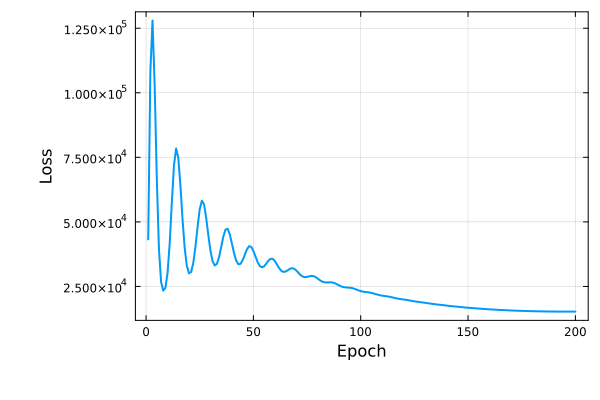

In [64]:
# 損失関数(Loss function)が学習とともに減少しているか確認
plot(loss_train, 
     linewidth=2, 
     xlabel="Epoch", ylabel="Loss", label=nothing,  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [ ]:
# 学習後のドッキングスコアをプロット
aftertrain_score_k = docking_score_elec(receptor_k, ligands_k, m.A[1], m.iface_score, m.B[1], m.charge)

scatter(rmsds_k, score_k, 
        label="Before training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 15.0))

scatter!(rmsds_k, train_score_k, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 15.0))

scatter!(rmsds_k, aftertrain_score_k, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 15.0))

In [66]:
loss_k_before = sum((train_score_k - score_k).^2) / 100

7.145622458708812e6

In [67]:
loss_k_after = sum((aftertrain_score_k - train_score_k).^2) / 100

7.196994590515649e6

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


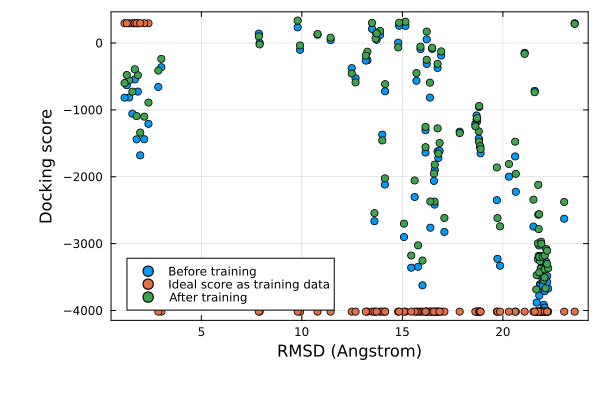

In [68]:
aftertrain_score_f = docking_score_elec(receptor_f, ligands_f, m.A[1], m.iface_score, m.B[1], m.charge)
scatter(rmsds_f, score_f,
        label="Before training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_f, train_score_f, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_f, aftertrain_score_f, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [69]:
loss_f_before = sum((score_f - train_score_f).^2) / 100

6.415742919488405e6

In [70]:
loss_f_after = sum((aftertrain_score_f - train_score_f).^2) / 100

6.760781977009004e6

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


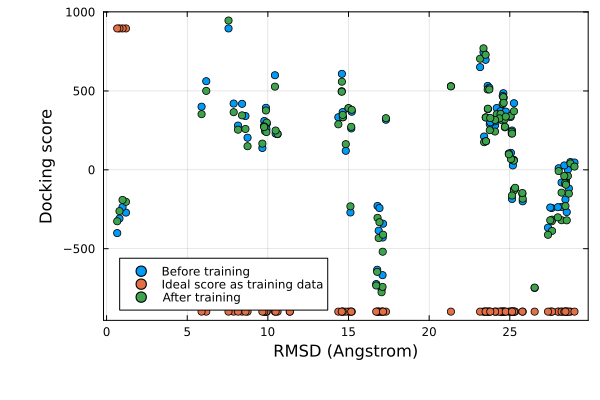

In [71]:
aftertrain_score_2v = docking_score_elec(receptor_2v, ligands_2v, m.A[1], m.iface_score, m.B[1], m.charge)
scatter(rmsds_2v, score_2v,
        label="Before training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_2v, train_score_2v, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds_2v, aftertrain_score_2v, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [72]:
loss_2v_before = sum((score_2v - train_score_2v).^2) / 100

1.1969723346963788e6

In [73]:
loss_2v_after = sum((aftertrain_score_2v - train_score_2v).^2) / 100

1.1546495658261008e6

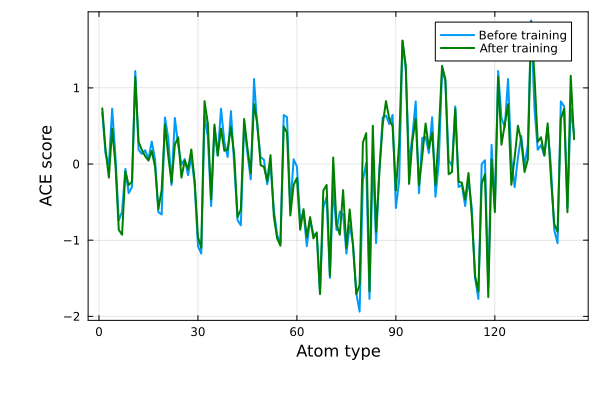

In [74]:
# 学習後の ace_scores をプロット
plot(iface_score[1:end], 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="Before training",  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

plot!(m.iface_score, 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="After training",
     linecolor=:green
,
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

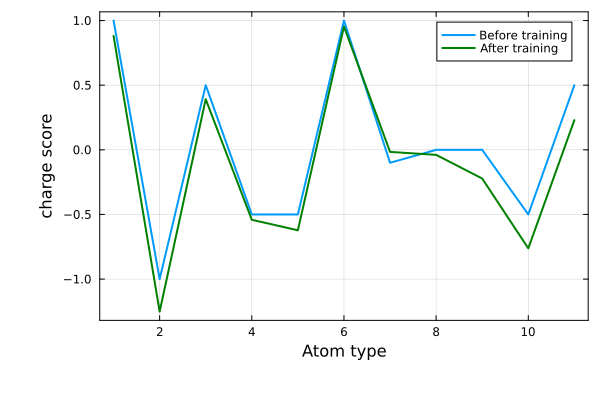

In [116]:
# 学習後の ace_scores をプロット
plot(charge[1:end], 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="Before training",  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

plot!(m.charge, 
     linewidth=2, 
     xlabel="Atom type", ylabel="charge score", label="After training",
     linecolor=:green,
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [76]:
charge

11-element Vector{Float64}:
  1.0
 -1.0
  0.5
 -0.5
 -0.5
  1.0
 -0.1
  0.0
  0.0
 -0.5
  0.5

In [77]:
m.charge

11-element Vector{Float64}:
  0.8810859017396302
 -1.2516117230362345
  0.39169932590646656
 -0.541326795421053
 -0.6224598989726209
  0.9539005164742509
 -0.01595881873387269
 -0.03898181360212097
 -0.2222235269379909
 -0.7621727808113634
  0.22921753387205085

In [78]:
iface_score

12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [83]:
m.A

1-element Vector{Float64}:
 -0.002946515377831102

In [84]:
m.B

1-element Vector{Float64}:
 3.1886899793155012

In [85]:
m.iface_score

144-element Vector{Float64}:
  0.7310509144334219
  0.18567156844159943
 -0.17853260096734783
  0.4649733027509462
 -0.014213163168360163
 -0.8626497675533022
 -0.9287212752736927
 -0.09824202371520273
 -0.2762457020617564
 -0.2316065581880259
  1.1433926715480909
  0.2919517127648974
  0.18567156844159943
  ⋮
  0.2919517127648974
  0.35084955402730417
  0.11358915033070503
  0.5340297334160212
 -0.18356543546469556
 -0.7880900937737982
 -0.8891411608680022
  0.5940601920240586
  0.7245067812918737
 -0.6322121504035464
  1.1593588947885411
  0.32581500540645286

In [86]:
iface_trained = m.iface_score

144-element Vector{Float64}:
  0.7310509144334219
  0.18567156844159943
 -0.17853260096734783
  0.4649733027509462
 -0.014213163168360163
 -0.8626497675533022
 -0.9287212752736927
 -0.09824202371520273
 -0.2762457020617564
 -0.2316065581880259
  1.1433926715480909
  0.2919517127648974
  0.18567156844159943
  ⋮
  0.2919517127648974
  0.35084955402730417
  0.11358915033070503
  0.5340297334160212
 -0.18356543546469556
 -0.7880900937737982
 -0.8891411608680022
  0.5940601920240586
  0.7245067812918737
 -0.6322121504035464
  1.1593588947885411
  0.32581500540645286

In [103]:
charge_trained =　m.charge

11-element Vector{Float64}:
  0.8810859017396302
 -1.2516117230362345
  0.39169932590646656
 -0.541326795421053
 -0.6224598989726209
  0.9539005164742509
 -0.01595881873387269
 -0.03898181360212097
 -0.2222235269379909
 -0.7621727808113634
  0.22921753387205085

In [95]:
using DataFrames, CSV

In [111]:

# DataFrameを作成するために配列を辞書形式に変換
# 列名を作成
column_names = [Symbol("Column" * string(i)) for i in 1:size(hoho, 2)]


# 二次元配列を DataFrame に変換
df = DataFrame(hoho, column_names)

# DataFrameをCSVファイルとして保存
CSV.write("iface_after.csv", df, header=false)



"iface_after.csv"

In [112]:
huhu = reshape(iface_score,12,12)

# DataFrameを作成するために配列を辞書形式に変換
# 列名を作成
column_names = [Symbol("Column" * string(i)) for i in 1:size(hoho, 2)]


# 二次元配列を DataFrame に変換
df = DataFrame(huhu, column_names)

# DataFrameをCSVファイルとして保存
CSV.write("iface_before.csv", df, header=false)

"iface_before.csv"

In [114]:
charge_before = [1.0, -1.0,  0.5, -0.5, -0.5,  1.0, -0.1,  0.0,  0.0, -0.5,  0.5]
charge_after = charge_trained
# リストを辞書形式でまとめる
data = Dict(
#      "charge_before" => charge_before,
     "charge_after" => charge_after,
)

# DataFrameを作成
df = DataFrame(data)

# DataFrameの内容を確認
println(df)

# # CSVファイルとして出力
CSV.write("charge_after.csv", df, header=false)


11×1 DataFrame
 Row │ charge_after 
     │ Float64      
─────┼──────────────
   1 │    0.881086
   2 │   -1.25161
   3 │    0.391699
   4 │   -0.541327
   5 │   -0.62246
   6 │    0.953901
   7 │   -0.0159588
   8 │   -0.0389818
   9 │   -0.222224
  10 │   -0.762173
  11 │    0.229218


"charge_after.csv"

In [115]:
m.charge .- charge 

11-element Vector{Float64}:
 -0.1189140982603698
 -0.25161172303623447
 -0.10830067409353344
 -0.041326795421053
 -0.12245989897262088
 -0.04609948352574911
  0.08404118126612731
 -0.03898181360212097
 -0.2222235269379909
 -0.2621727808113634
 -0.27078246612794915

In [126]:
for i in 1:100
    println(score_f[i])
end

-3605.137350000001
-3914.6700249999994
-3882.11145
-2744.8943000000004
-3709.678100000001
5.874799999999709
-3233.1753999999996
-3623.993299999999
-3578.05665
-3477.8505249999994
-3182.3779250000002
-814.440925
-257.0916000000001
-86.91900000000027
-2566.745075
-91.31170000000009
-726.1853499999997
-1208.5354249999998
118.89477499999975
-3777.141450000001
-1619.627625
-187.4548
-4016.6461249999998
-3622.7967500000004
-375.59902500000015
157.35975000000013
-3346.0436750000003
-3427.412300000001
-1082.967025
-3710.8815499999996
-2416.43335
-3269.312925
-1720.04165
-2224.6196250000003
-1170.2948250000002
-3670.8789500000003
-1695.8938999999996
-361.7877749999999
-312.97564999999975
-817.0279000000004
-1056.0393000000001
211.7148749999999
-630.4708500000002
-1450.1072250000002
-2115.976375
-544.9459250000001
-1438.628775
-372.8665500000001
-2350.496225
-1428.2312250000004
-1210.0024750000002
-3994.0518249999996
-563.8147500000002
-2761.4015500000005
-957.7068500000003
-2302.4159750000003
-

In [129]:
for i in 1:100
    println(aftertrain_score_2v[i])
end

460.6598134321591
-319.40506764807674
328.3178871375767
-231.4184188146158
314.02083492817314
-326.077222119269
319.3521429676528
331.6240645271189
-776.0499670860712
241.38556436717124
40.54630550657646
244.47103882483225
-81.3051935903178
-85.43043879545678
60.82409606036117
58.198990156736386
387.4339300805676
228.05518490970394
-202.6690989361013
299.17502457253045
558.5348368186001
352.2127281588215
376.07144496054957
-94.2068684009771
68.14298068693381
-432.2622795009603
416.9916493673536
354.25395959978835
345.1503304717444
-319.8380917490938
-320.1332086496775
175.05796484872144
-130.77641827751722
242.7908148706947
424.49774194884355
332.8891289192509
391.1248135087852
509.2069456142058
527.2368132307541
-190.75092612842377
-38.921289030455
98.27204240961942
275.08945758922573
365.3232841274886
-7.98732814498419
-261.67045642601425
946.1725388746312
-778.3063292246667
239.09792405522842
270.8715553072261
327.4017739455777
-301.2800347482621
-742.1398601965943
770.0209107730554

In [130]:
for i in 1:100
    println(rmsds_2v[i])
end

24.6
28.21
24.47
15.12
24.51
27.6
24.68
23.51
17.05
25.12
28.76
9.83
28.48
28.42
25.19
25.25
23.64
10.6
1.2
9.93
14.59
24.19
9.88
28.48
25.07
16.87
24.56
24.43
8.4
27.51
28.53
23.41
25.26
24.08
24.62
14.65
15.0
23.63
10.44
0.99
28.6
24.94
9.78
7.88
28.03
0.8
7.56
11.36
9.91
9.77
17.32
27.98
17.11
23.37
27.62
8.74
8.61
26.54
6.18
24.7
25.33
27.37
15.2
25.14
25.8
28.21
24.36
28.66
16.8
14.37
23.16
24.09
29.01
28.38
16.92
10.48
8.15
17.12
14.83
25.05
25.26
23.52
23.76
16.78
21.35
15.17
25.78
14.64
14.58
16.72
0.66
23.73
23.5
9.66
24.75
23.79
17.14
25.14
28.45
5.89


LoadError: BoundsError: attempt to access 100-element Vector{Float64} at index [101]